# Setup

## Load libraries

In [1]:
if (!require("xfun")) install.packages("xfun")

pkgs <- c(
  'urca', 'uroot', 'vars', 'forecast', 'dynlm', 'tsDyn', "aod", 
  'lubridate', 'tsbox', 'timetk', 'xts', 'tsibble', 'mltools',
  'tidyverse', 'readr', 'vroom', 'readxl', 'writexl', 
  'rlist', 'here', 'forcats', "janitor", 'data.table', 
  'extrafont', 'patchwork', 'hrbrthemes', 'ggthemes', 'ggsci', 'scales',
  'kableExtra', 'gt', 'reshape2'
)
xfun::pkg_attach2(pkgs, message = TRUE)

loadfonts(device = "win", quiet = TRUE)
setwd(here())

# source("R/granger_ty.R")
source("R/tsa.R")

Loading required package: xfun


Attaching package: 'xfun'


The following objects are masked from 'package:base':

    attr, isFALSE


Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: lmtest


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'tsibble'


The following object is masked from 'package:lubridate':

    interval


The following object is masked from 'package:zoo':

    index


The following objects are masked from 'package:base':

    intersect, setdiff, union



Attaching package: 'mltools'


The following object is masked from 'package:tsDyn':

    mse


-- Attaching packages -----------------------------------------------------------------------------

## Load data

In [2]:
price <- readRDS('data/rice/clean/rice_price.rds') %>%
  filter(date >= '2004-01-01') %>%
  mutate(
    across(phf:pwx, log),
    month = factor(month(date))
  )

price <- one_hot(as.data.table(price)) %>% 
  as_tsibble(index = date) %>% 
  select(-month_12)

price

date,phf,phw,phx,pwf,pww,pwx,d_foodcrisis,d_pledge,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2004-01-01,9.077837,9.826379,9.983440,8.562167,8.956188,9.039711,0,0,1,0,0,0,0,0,0,0,0,0,0
2004-02-01,9.081484,9.778774,9.977384,8.545003,8.958990,9.036398,0,0,0,1,0,0,0,0,0,0,0,0,0
2004-03-01,9.111845,9.775654,9.977257,8.517193,9.073739,9.140171,0,0,0,0,1,0,0,0,0,0,0,0,0
2004-04-01,9.140883,9.766252,9.978467,8.560827,9.082641,9.156982,0,0,0,0,0,1,0,0,0,0,0,0,0
2004-05-01,9.127937,9.731215,9.975262,8.585226,9.082592,9.146003,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,9.682529,10.41524,10.51372,8.974238,9.372824,9.481257,0,0,0,0,0,0,0,0,0,1,0,0,0
2019-09-01,9.714866,10.45278,10.53318,8.965335,9.354441,9.464204,0,0,0,0,0,0,0,0,0,0,1,0,0
2019-10-01,9.698368,10.45305,10.51031,8.977273,9.341577,9.451832,0,0,0,0,0,0,0,0,0,0,0,1,0


In [414]:
# price <- price %>%
#   mutate(
#     d_foodcrisis = ifelse(date >= '2007-11-01' & date <= '2008-06-01', 1, 0),
#     d_pledge = ifelse(date >= '2011-09-01' & date <= '2014-01-01', 1, 0)
#   )

# Hommali

In [4]:
endo_h <- price %>% as_tibble() %>% select(phf, phw, phx)
exo_h  <- price %>% as_tibble() %>% select(d_foodcrisis, d_pledge, starts_with("month"))

## Descriptive Analysis

In [416]:
endo_h %>% exp() %>%
  psych::describe() %>%
  rownames_to_column("varname") %>%
  select(varname, mean, sd, min, max) %>%
  write_xlsx("results/tbl_1_desc_h.xlsx")

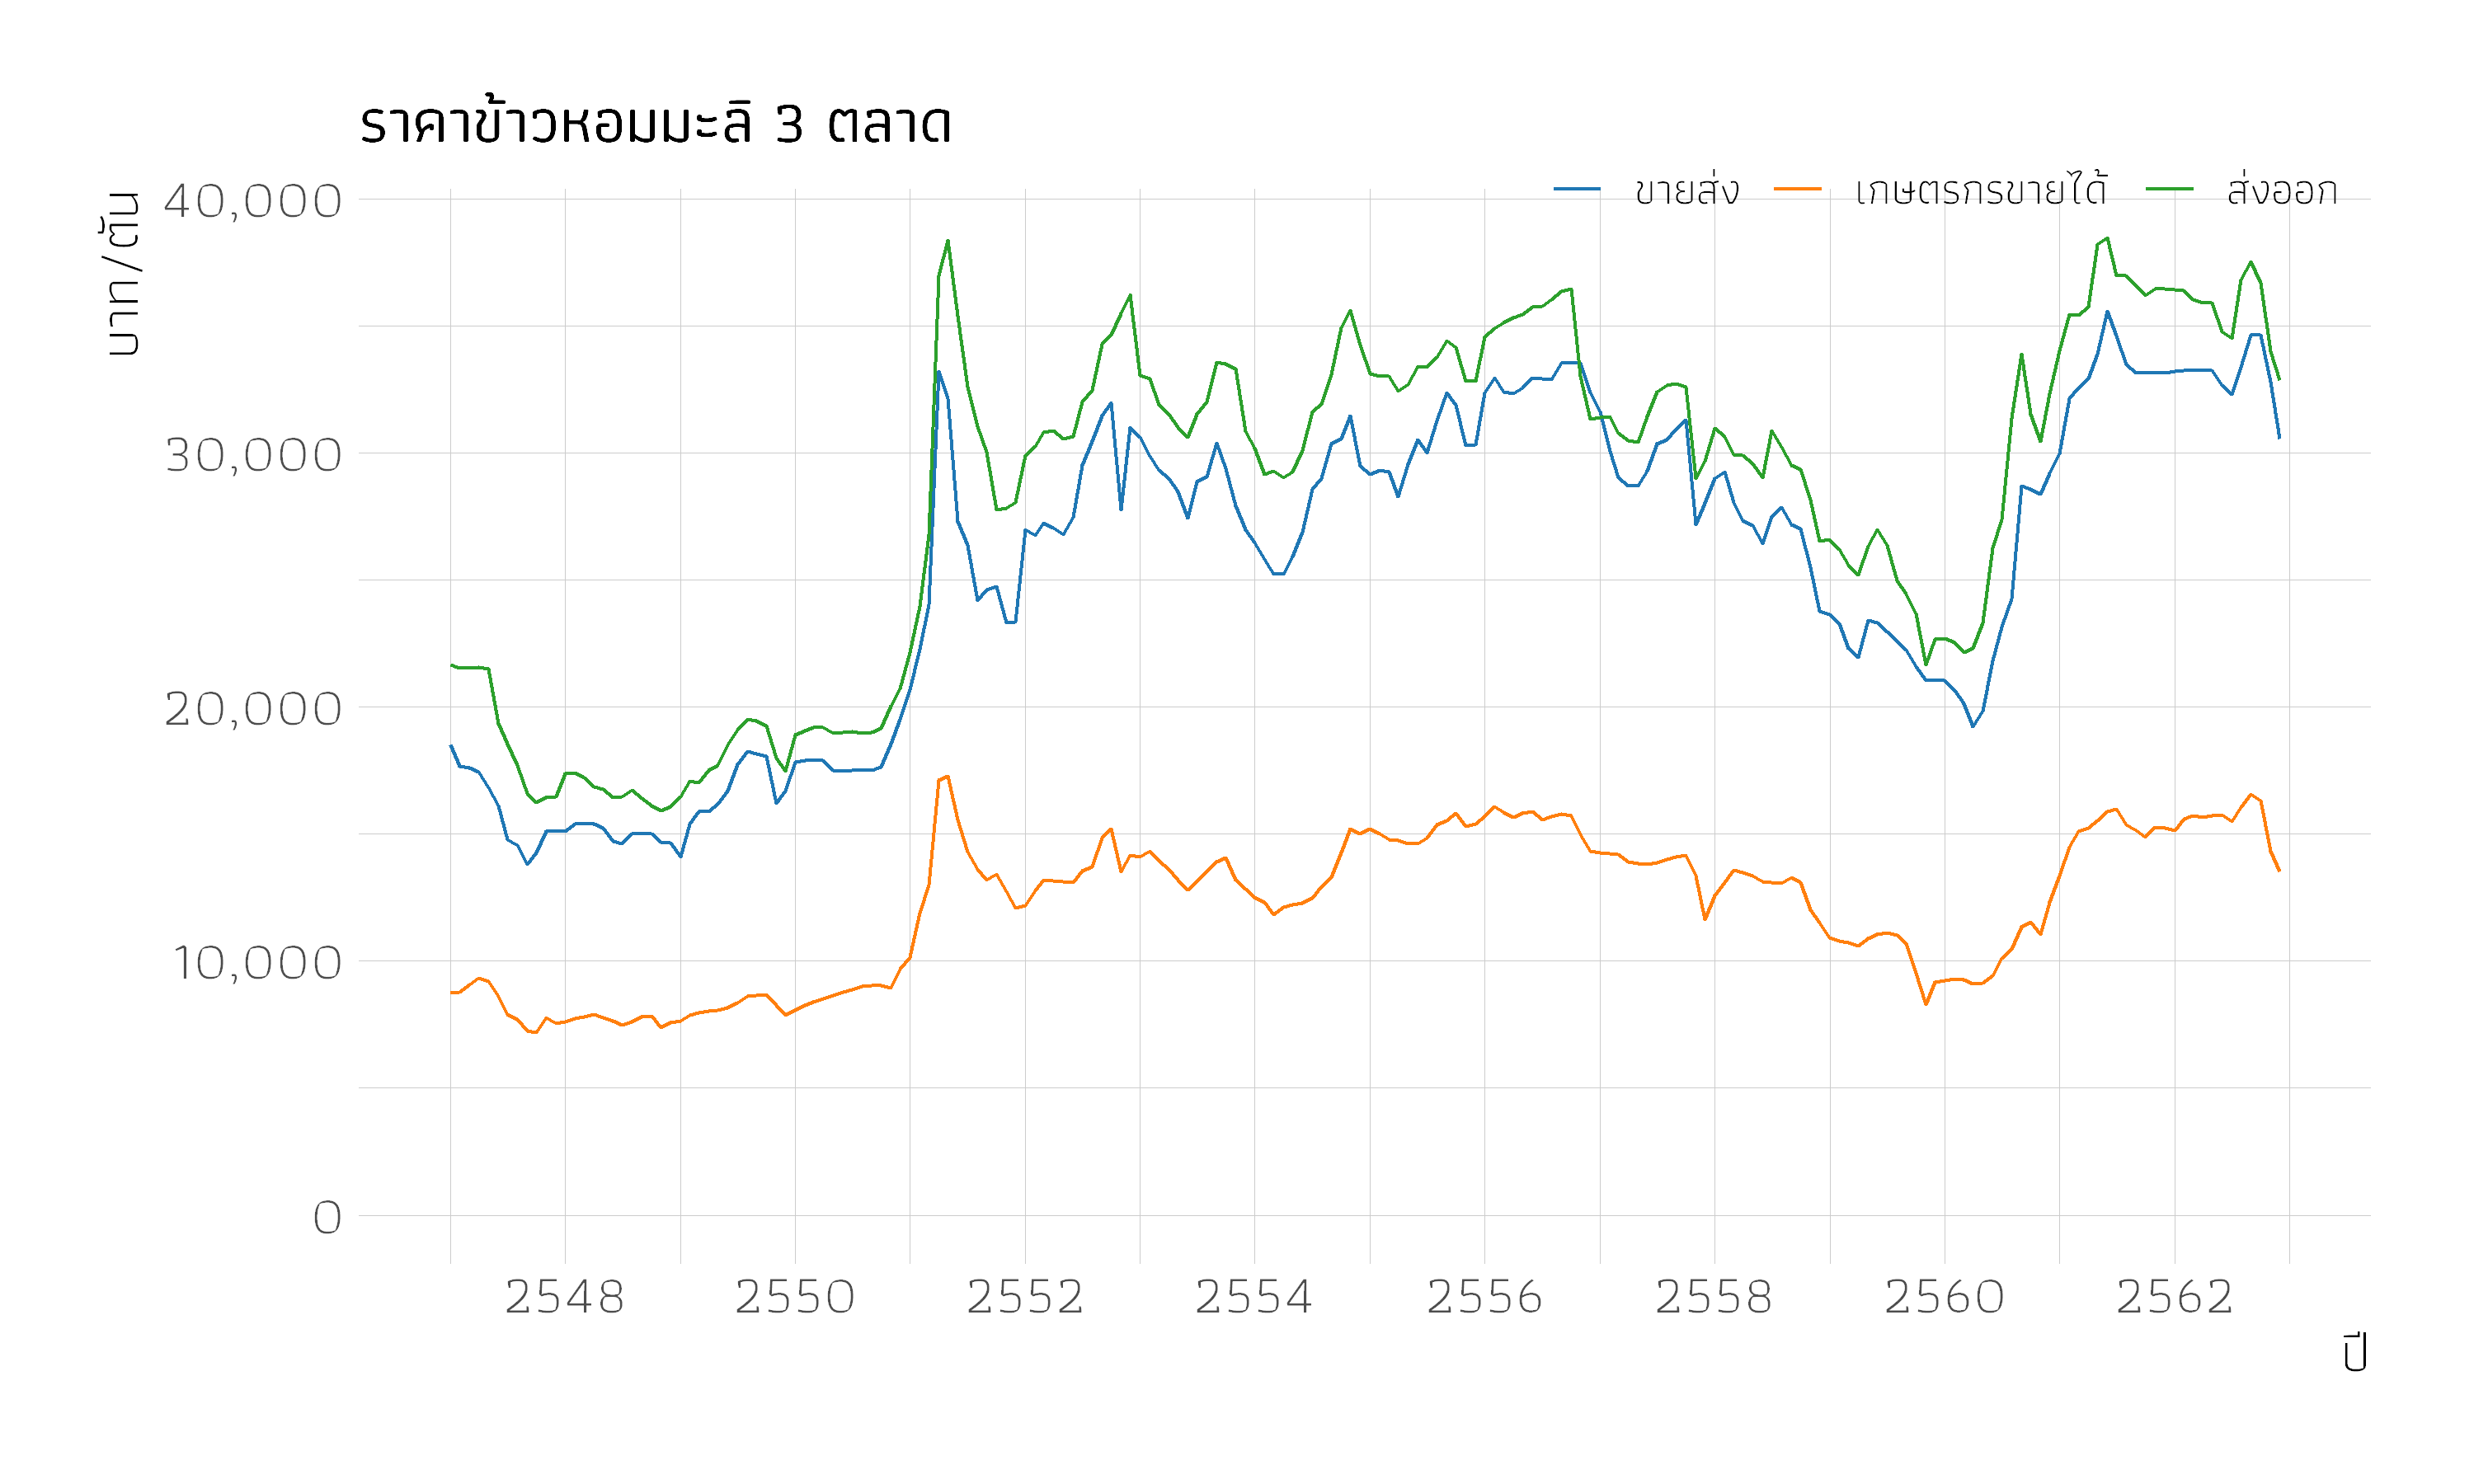

In [5]:
options(
  repr.plot.width = 10,
  repr.plot.height = 6 
)

price %>% 
  ggplot(aes(x=date)) +
    geom_line( aes(y=phf %>% exp(), color = 'เกษตรกรขายได้')) +
    geom_line( aes(y=phw %>% exp(), color = 'ขายส่ง')) +
    geom_line( aes(y=phx %>% exp(), color = 'ส่งออก')) +
    scale_color_d3() +
    expand_limits(y = 0) +
    scale_y_continuous(label = comma) +
    labs(title = 'ราคาข้าวหอมมะลิ 3 ตลาด',
         x =  "ปี",
         y = 'บาท/ตัน'
        ) +
    theme_ipsum(
      base_size = 16,
      base_family = "Athiti Light",
      axis_title_size = 16
    ) +
    theme(
      legend.position = c(1, 1),
      legend.direction = 'horizontal',
      legend.justification = 'right',
      legend.title = element_blank()
    ) +
    scale_x_date(date_breaks = '2 years',
                 labels = function(x) year(x)+543
                 )

# ggsave('figures/fig_1_h.png', width = 10, height = 6)

## Unit Root Test

In [48]:
# urca::ur.df(
#   price %>% select('pwx') %>% ts_ts %>% diff(), 
#   type = 'drift') %>% summary

In [89]:
ph_names <- c('phf', 'phw', 'phx')

expand_grid(
  'varname' = ph_names, 
  'n_diff' = c(0,1)
) %>% 
  pmap(tsa_ur_adf, y = price, specs = c('trend', 'drift')) %>%
  reduce(bind_rows) %>% 
  tsa_report_adf() %>% 
  write_xlsx("results/tbl_2_unit_root_h.xlsx")

[time]: 'date' [value]: 'phf' 

[time]: 'date' [value]: 'phf' 

[time]: 'date' [value]: 'phw' 

[time]: 'date' [value]: 'phw' 

[time]: 'date' [value]: 'phx' 

[time]: 'date' [value]: 'phx' 



variable,d0_trend,d0_constant,d1_trend,d1_constant
<chr>,<chr>,<chr>,<chr>,<chr>
phf,-2.156 [1],-2.153 [1],-7.729***[1],-7.702***[1]
phw,-2.088 [1],-2.059 [1],-9.130***[1],-9.105***[1]
phx,-2.349 [1],-2.281 [1],-8.237***[1],-8.207***[1]


## Optimal Lag

In [417]:
varselect <- VARselect(endo_h, exogen = exo_h, lag.max = 10, type = 'both')
varselect

,1,2,3,4,5,6,7,8,9,10
AIC(n),-2.041955e+01,-2.043293e+01,-2.046425e+01,-2.038198e+01,-2.035079e+01,-2.028235e+01,-2.024015e+01,-2.019241e+01,-2.013470e+01,-2.009538e+01
HQ(n),-2.003417e+01,-1.998333e+01,-1.995042e+01,-1.980392e+01,-1.970849e+01,-1.957583e+01,-1.946940e+01,-1.935743e+01,-1.923549e+01,-1.913194e+01
SC(n),-1.946891e+01,-1.932385e+01,-1.919674e+01,-1.895602e+01,-1.876639e+01,-1.853952e+01,-1.833888e+01,-1.813269e+01,-1.791654e+01,-1.771878e+01
FPE(n),1.357528e-09,1.341019e-09,1.301667e-09,1.416098e-09,1.464607e-09,1.573141e-09,1.647014e-09,1.735153e-09,1.847742e-09,1.933395e-09


In [418]:
varselect$criteria %>% t %>% 
  as_tibble %>% 
  rownames_to_column('lag') %>%
  write_xlsx("results/tbl_3_optimal_lag_h.xlsx")

## Deterministic Term

In [420]:
tsa_select_DT <- function(endo, ...) {
  
  # estimate 5 specification of VECM
  
  spec1 <- tsDyn::VECM(endo, estim = "ML", include = 'none', ...) %>% suppressWarnings()
  spec2 <- tsDyn::VECM(endo, estim = "ML", LRinclude = 'const', ...) %>% suppressWarnings()
  spec3 <- tsDyn::VECM(endo, estim = "ML", include = 'const', ...) %>% suppressWarnings()
  spec4 <- tsDyn::VECM(endo, estim = "ML", include = 'const', LRinclude = 'trend', ...) %>% suppressWarnings()
  spec5 <- tsDyn::VECM(endo, estim = "ML", include = 'both', ...) %>% suppressWarnings()
  
  res <- list(spec1, spec2, spec3, spec4, spec5)
  tibble(
    model = 1:length(res),
    AIC = res %>% map_dbl(AIC),
    BIC = res %>% map_dbl(BIC)
  )
}

tsa_select_DT(endo_h, exogen = exo_h, lag = 1) %>%
  write_xlsx("results/tbl_a1_model_spec.xlsx")

## Cointegration Test

In [49]:
vecm_h <- tsDyn::VECM(
  endo_h, exogen = exo_h, lag = 1,
  estim = "ML", LRinclude = 'const',
  ) %>% suppressWarnings()

In [61]:
summary(vecm_h)$coefMat %>% as.data.frame %>% 
  rownames_to_column() %>%
  write_xlsx("results/vecm_ph.xlsx")

Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"


In [422]:
vecm_h <- tsDyn::VECM(
  endo_h, exogen = exo_h, lag = 1,
  estim = "ML", LRinclude = 'const',
  ) %>% suppressWarnings()

rank.test(vecm_h) %>% summary() %>%
  select(-trace_pval_T) %>%
  write_xlsx("results/tbl_4_rank_test.xlsx")

## VECM

In [5]:
vecm_h <- tsDyn::VECM(
  endo_h, exogen = exo_h, lag = 1, r = 2,
  estim = "ML", LRinclude = 'const',
  ) %>% suppressWarnings()

In [6]:
vecm_h %>% summary

Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"


#############
###Model VECM 
#############
Full sample size: 192 	End sample size: 190
Number of variables: 3 	Number of estimated slope parameters 54
AIC -3888.313 	BIC -3706.479 	SSR 0.8342457
Cointegrating vector (estimated by ML):
             phf phw        phx      const
r1  1.000000e+00   0 -0.8632358 -0.5454575
r2 -5.551115e-17   1 -1.0059131  0.1505543


             ECT1               ECT2                phf -1             
Equation phf -0.2724(0.0573)*** 0.1800(0.0685)**    0.0228(0.0922)     
Equation phw -0.1346(0.0694).   -0.0076(0.0829)     -0.0699(0.1116)    
Equation phx -0.1160(0.0619).   0.2182(0.0739)**    0.0545(0.0995)     
             phw -1              phx -1            d_foodcrisis     
Equation phf 0.0231(0.1007)      0.2776(0.1093)*   0.0620(0.0157)***
Equation phw -0.1526(0.1219)     0.4309(0.1322)**  0.0471(0.0190)*  
Equation phx -0.1418(0.1087)     0.3246(0.1179)**  0.0629(0.0169)***
             d_pledge           month_1            month_2            

In [424]:
vecm_h$model.specific$beta

,r1,r2
phf,1.0000000,-5.551115e-17
phw,0.0000000,1.000000e+00
phx,-0.8632358,-1.005913e+00
const,-0.5454575,1.505543e-01


In [426]:
# vecm_h %>% summary %>% suppressWarnings()

In [427]:
vecm_h %>% 
  summary %>% suppressWarnings() %>% 
  '[['('bigcoefficients') %>% 
  t %>% 
  as.data.frame %>%
  rownames_to_column() %>%
  write_xlsx("results/tbl_5_vecm_h.xlsx")

In [64]:
# vecm_h_cajo <- ca.jo(endo_h, dumvar = exo_h, ecdet = "const", type="eigen", K=2, spec="transitory")
# vecm_h_ols <- cajools(vecm_h_cajo)
# vecm_h_ols %>% summary()

### Test

In [428]:
vecm_h_var <- tsDyn:::vec2var.tsDyn(vecm_h)
tsa_VAR_diag(vecm_h_var) %>%
  write_xlsx("results/tbl_a2_model_diag_h.xlsx")

In [429]:
bound_unit_circle <- function(x) {
  x <- ifelse(x > 1, 1, x)
  x <- ifelse(x < -1, -1, x)
  return(x)
}

# bound_unit_circle(Re(eigen(vecm_h_var$A$A1)$values))

In [430]:
library("plotrix")

options(
  repr.plot.width = 6,
  repr.plot.height = 6 
)

png(
  filename = "figures/fig_a1_stability_h.png",
  units = "in", 
  width = 6, 
  height = 6,
  pointsize = 10, 
  res = 300
)

x <- seq(-1, 1, length = 1000)
y1 <- sqrt(1-x^2)
y2 <- -sqrt(1-x^2)
plot(
  Re(eigen(vecm_h_var$A$A1)$values) %>% bound_unit_circle,
  Im(eigen(vecm_h_var$A$A1)$values) %>% bound_unit_circle,
  pch=19, col = "blue", 
  xlab = 'Real part', ylab = 'Complex part',
  ylim = c(-2, 2), xlim = c(-2, 2)
)
points(
  Re(eigen(vecm_h_var$A$A2)$values) %>% bound_unit_circle,
  Im(eigen(vecm_h_var$A$A2)$values) %>% bound_unit_circle,
  pch=19, col = "blue"
)
abline(h=0)
abline(v=0)
draw.circle(0, 0, 1, nv = 1000, border = NULL, col = NA, lty = 1, lwd = 1)

dev.off()

png 
  2

## Granger Casuality Test

In [431]:
tsa_gc_ty(
  endo_h, exogen = exo_h, 
  p=1, m=1, type = "const"
) %>% select(-wald)

x,y,chi2_stat,chi2_df,chi2_pval
<chr>,<chr>,<dbl>,<dbl>,<dbl>
phw,phf,4.0827743,1,4.332247e-02
phx,phf,9.2120779,1,2.404237e-03
phf,phw,2.5266134,1,1.119402e-01
phx,phw,17.6010764,1,2.724341e-05
phf,phx,0.2371593,1,6.262654e-01
phw,phx,0.4416404,1,5.063318e-01


In [432]:
tsa_gc_ty(
  endo_h, exogen = exo_h, 
  p=1, m=1, type = "const"
) %>% 
  select(-wald) %>%
  mutate(chi2_pval = round(chi2_pval, 5)) %>%
  write_xlsx("results/tbl_a3_granger_h.xlsx")

## IRF

In [433]:
vecm_h <- tsDyn::VECM(
  endo_h %>% select(1,2,3), exogen = exo_h, lag = 1, r = 2,
  estim = "ML", LRinclude = 'const',
  ) %>% suppressWarnings()

In [406]:
# tsDyn::irf(vecm_h, boot = TRUE, n.ahead = 36, ortho = TRUE)

In [434]:
for (i in c("phf", "phw", "phx")) {
  png(
    filename = glue::glue("figures/fig_3_irf1_{i}.png"),
    units = "in", 
    width = 7, 
    height = 7,
    pointsize = 12, 
    res = 300
  )
  tsDyn::irf(vecm_h, impulse = i, boot = TRUE, n.ahead = 24, ortho = TRUE) %>% plot
  dev.off()  
}

# White Rice

In [435]:
endo_w <- price %>% as_tibble() %>% select(pwf, pww, pwx)
exo_w  <- price %>% as_tibble() %>% select(d_foodcrisis, d_pledge)

,1,2,3,4,5,6,7,8,9,10
AIC(n),-2.150931e+01,-2.168360e+01,-2.168206e+01,-2.166197e+01,-2.164839e+01,-2.166549e+01,-2.162597e+01,-2.156434e+01,-2.150197e+01,-2.145809e+01
HQ(n),-2.135945e+01,-2.146950e+01,-2.140373e+01,-2.131942e+01,-2.124160e+01,-2.119447e+01,-2.109072e+01,-2.096487e+01,-2.083827e+01,-2.073016e+01
SC(n),-2.113962e+01,-2.115546e+01,-2.099548e+01,-2.081696e+01,-2.064493e+01,-2.050360e+01,-2.030563e+01,-2.008557e+01,-1.986476e+01,-1.966243e+01
FPE(n),4.556934e-10,3.828940e-10,3.836368e-10,3.916671e-10,3.973933e-10,3.911518e-10,4.076044e-10,4.344447e-10,4.636393e-10,4.860219e-10


## Descriptive Analysis

In [190]:
endo_w %>% exp() %>%
  psych::describe() %>% 
  rownames_to_column("varname") %>%
  select(varname, mean, sd, min, max) %>%
  write_xlsx("results/tbl_1_desc_w.xlsx")

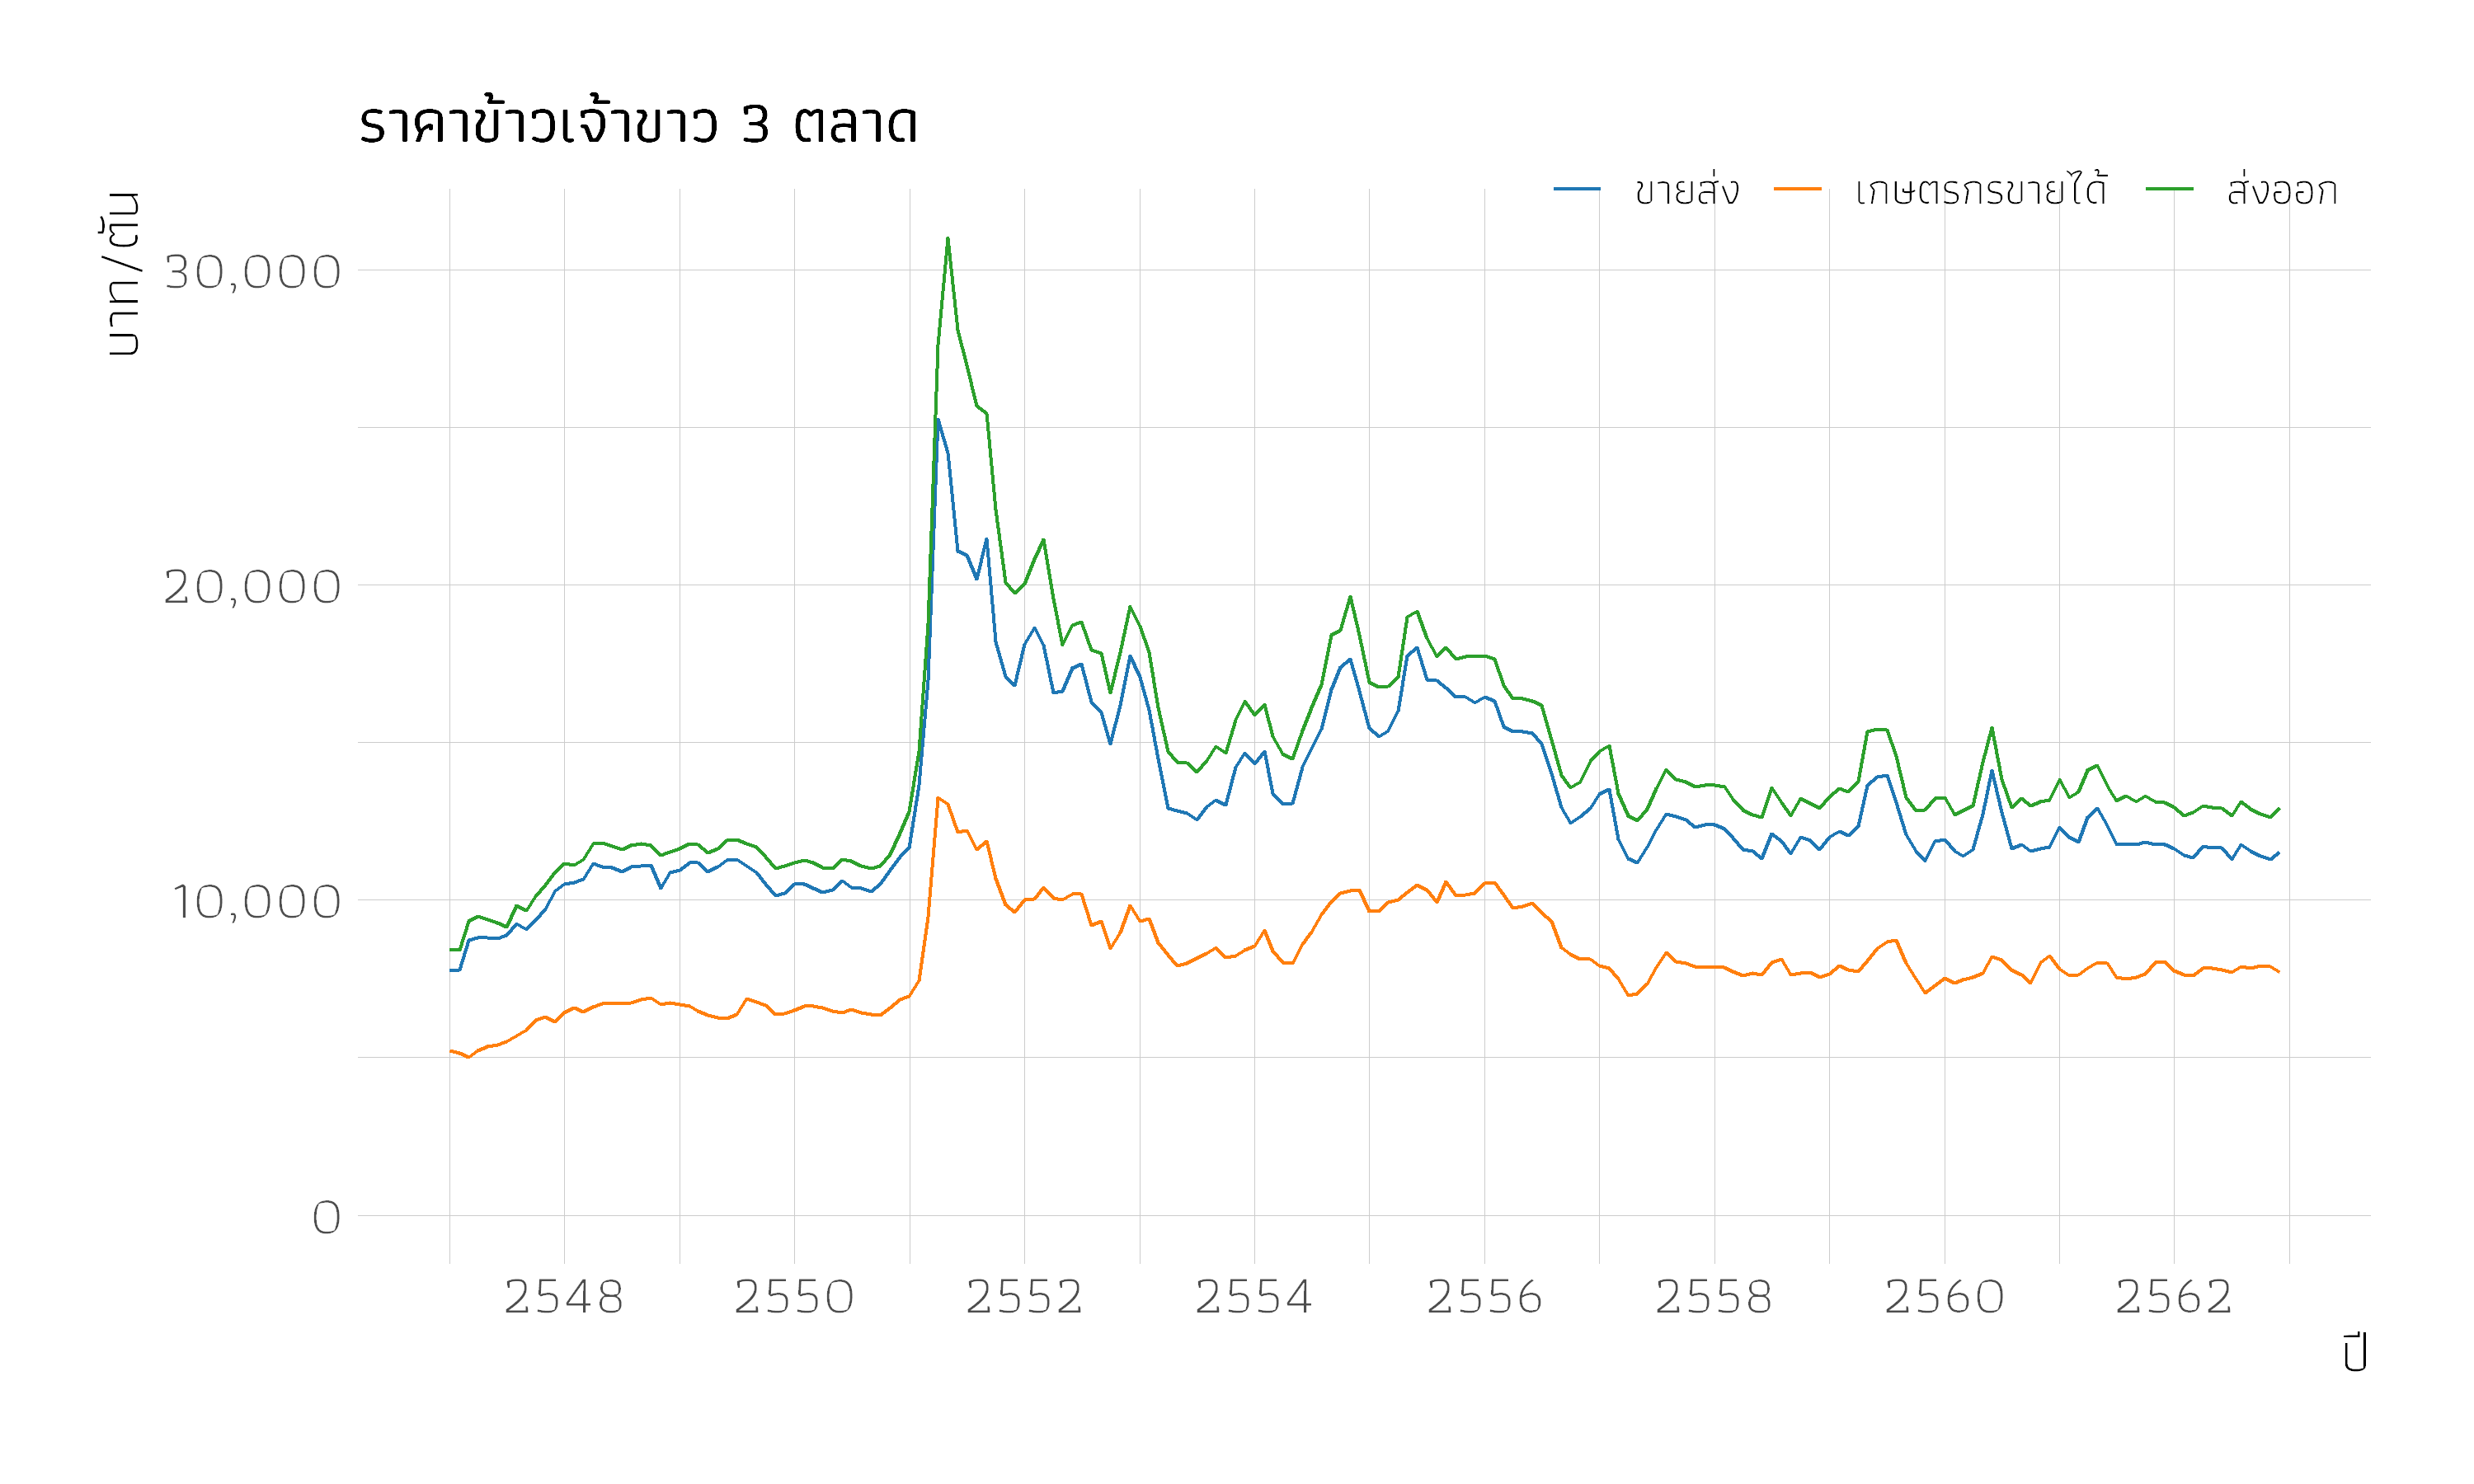

In [191]:
options(
  repr.plot.width = 10,
  repr.plot.height = 6 
)

price %>% 
  ggplot(aes(x=date)) +
    geom_line( aes(y=pwf %>% exp(), color = 'เกษตรกรขายได้')) +
    geom_line( aes(y=pww %>% exp(), color = 'ขายส่ง')) +
    geom_line( aes(y=pwx %>% exp(), color = 'ส่งออก')) +
    scale_color_d3() +
    expand_limits(y = 0) +
    scale_y_continuous(label = comma) +
    labs(title = 'ราคาข้าวเจ้าขาว 3 ตลาด',
         x =  "ปี",
         y = 'บาท/ตัน'
        ) +
    theme_ipsum(
      base_size = 16,
      base_family = "Athiti Light",
      axis_title_size = 16
    ) +
    theme(
      legend.position = c(1, 1),
      legend.direction = 'horizontal',
      legend.justification = 'right',
      legend.title = element_blank()
    ) +
    scale_x_date(date_breaks = '2 years',
                 labels = function(x) year(x)+543
                 )

ggsave('figures/fig_1_w.png', width = 10, height = 6)

## Unit Root Test

In [193]:
p_w_names <- c('pwf', 'pww', 'pwx')

expand_grid(
  'varname' = p_w_names, 
  'n_diff' = c(0,1)
) %>% 
  pmap(tsa_ur_adf, y = price) %>%
  reduce(bind_rows) %>% 
  tsa_report_adf() %>% 
  write_xlsx("results/tbl_2_unit_root_w.xlsx")

[time]: 'date' [value]: 'pwf' 

[time]: 'date' [value]: 'pwf' 

[time]: 'date' [value]: 'pww' 

[time]: 'date' [value]: 'pww' 

[time]: 'date' [value]: 'pwx' 

[time]: 'date' [value]: 'pwx' 



## Optimal Lag

In [436]:
varselect <- VARselect(endo_w, exogen = exo_w, lag.max = 10, type = 'both')
varselect

,1,2,3,4,5,6,7,8,9,10
AIC(n),-2.150931e+01,-2.168360e+01,-2.168206e+01,-2.166197e+01,-2.164839e+01,-2.166549e+01,-2.162597e+01,-2.156434e+01,-2.150197e+01,-2.145809e+01
HQ(n),-2.135945e+01,-2.146950e+01,-2.140373e+01,-2.131942e+01,-2.124160e+01,-2.119447e+01,-2.109072e+01,-2.096487e+01,-2.083827e+01,-2.073016e+01
SC(n),-2.113962e+01,-2.115546e+01,-2.099548e+01,-2.081696e+01,-2.064493e+01,-2.050360e+01,-2.030563e+01,-2.008557e+01,-1.986476e+01,-1.966243e+01
FPE(n),4.556934e-10,3.828940e-10,3.836368e-10,3.916671e-10,3.973933e-10,3.911518e-10,4.076044e-10,4.344447e-10,4.636393e-10,4.860219e-10


In [443]:
varselect$criteria %>% t %>% 
  as_tibble %>% 
  rownames_to_column('lag') %>%
  write_xlsx("results/tbl_3_optimal_lag_w.xlsx")

In [445]:
VAR(endo_w, exogen = exo_w, p = 2, type = "both") %>% tsa_VAR_diag

method,Chi-sq,df,p.value
<chr>,<dbl>,<dbl>,<dbl>
Portmanteau Test (asymptotic),128.89304,90,4.516058e-03
ARCH (multivariate),631.68878,432,1.091574e-09
JB-Test (multivariate),470.71772,6,0.000000e+00
Skewness only (multivariate),32.95401,3,3.293414e-07
Kurtosis only (multivariate),437.76371,3,0.000000e+00


## Test

In [498]:
VAR(endo_w, exogen = exo_w, p = 2, type = "both") %>% 
  tsa_VAR_diag %>%
  write_xlsx("results/tbl_a2_model_diag_w2.xlsx")

In [499]:
VAR(endo_w, exogen = exo_w, p = 6, type = "both") %>% 
  tsa_VAR_diag %>%
  write_xlsx("results/tbl_a2_model_diag_w6.xlsx")

In [473]:
var_w <- tsDyn::lineVar(
  endo_w, exogen = exo_w, lag = 6, 
  model = "VAR", include = "both", r = 1
) %>% suppressWarnings()

In [454]:
var_w %>% 
  summary %>% suppressWarnings() %>% 
  '[['('bigcoefficients') %>% 
  t %>% 
  as.data.frame %>%
  rownames_to_column() %>%
  write_xlsx("results/tbl_5_var_w.xlsx")

In [496]:
# var_w %>% str()

In [ ]:
library("plotrix")

options(
  repr.plot.width = 6,
  repr.plot.height = 6 
)

png(
  filename = "figures/fig_a1_stability_w.png",
  units = "in", 
  width = 6, 
  height = 6,
  pointsize = 10, 
  res = 300
)

x <- seq(-1, 1, length = 1000)
y1 <- sqrt(1-x^2)
y2 <- -sqrt(1-x^2)
plot(
  Re(eigen(var_h_var$A$A1)$values) %>% bound_unit_circle,
  Im(eigen(vecm_h_var$A$A1)$values) %>% bound_unit_circle,
  pch=19, col = "blue", 
  xlab = 'Real part', ylab = 'Complex part',
  ylim = c(-2, 2), xlim = c(-2, 2)
)
points(
  Re(eigen(vecm_h_var$A$A2)$values) %>% bound_unit_circle,
  Im(eigen(vecm_h_var$A$A2)$values) %>% bound_unit_circle,
  pch=19, col = "blue"
)
abline(h=0)
abline(v=0)
draw.circle(0, 0, 1, nv = 1000, border = NULL, col = NA, lty = 1, lwd = 1)

dev.off()

In [475]:
var_w <- VAR(endo_w, exogen = exo_w, p = 6, type = "both")

In [491]:
var_w %>% summary


VAR Estimation Results:
Endogenous variables: pwf, pww, pwx 
Deterministic variables: both 
Sample size: 186 
Log Likelihood: 1287.449 
Roots of the characteristic polynomial:
0.9241 0.8364 0.8364 0.8012 0.7918 0.7918 0.7894 0.7894 0.7355 0.7355 0.7114 0.7114 0.7011 0.7011 0.6896 0.6896 0.3499 0.3499
Call:
VAR(y = endo_w, p = 6, type = "both", exogen = exo_w)


Estimation results for equation pwf: 
pwf = pwf.l1 + pww.l1 + pwx.l1 + pwf.l2 + pww.l2 + pwx.l2 + pwf.l3 + pww.l3 + pwx.l3 + pwf.l4 + pww.l4 + pwx.l4 + pwf.l5 + pww.l5 + pwx.l5 + pwf.l6 + pww.l6 + pwx.l6 + const + trend + d_foodcrisis + d_pledge 

               Estimate Std. Error t value Pr(>|t|)    
pwf.l1        0.6946795  0.1263466   5.498 1.44e-07 ***
pww.l1        0.1898419  0.1824772   1.040 0.299704    
pwx.l1        0.3107644  0.1911773   1.626 0.105970    
pwf.l2       -0.1452544  0.1515782  -0.958 0.339332    
pww.l2       -0.2336693  0.2044853  -1.143 0.254821    
pwx.l2       -0.1014025  0.2394751  -0.423 0.672532

In [455]:
# tsDyn::lineVar(endo_w, exogen = exo_w, lag = 6, model = "VAR", include = "both") %>% summary

## Granger Casuality Test

In [466]:
tsa_gc_ty(
  endo_w, exogen = exo_w, 
  p = 6, m = 0, type = "both"
) %>% select(-wald)

x,y,chi2_stat,chi2_df,chi2_pval
<chr>,<chr>,<dbl>,<dbl>,<dbl>
pww,pwf,12.973540,6,0.0434580640
pwx,pwf,22.555514,6,0.0009598690
pwf,pww,2.999546,6,0.8089038165
pwx,pww,24.273534,6,0.0004650775
pwf,pwx,4.102141,6,0.6628561087
pww,pwx,12.910785,6,0.0444747695


In [467]:
tsa_gc_ty(
  endo_w, exogen = exo_w, 
  p = 6, m = 0, type = "both"
) %>% 
  select(-wald) %>%
  mutate(chi2_pval = round(chi2_pval, 5)) %>%
  write_xlsx("results/tbl_a3_granger_w.xlsx")

## IRF

In [492]:
for (i in c("pwf", "pww", "pwx")) {
  png(
    filename = glue::glue("figures/fig_3_irf_{i}.png"),
    units = "in", 
    width = 7, 
    height = 7,
    pointsize = 12, 
    res = 300
  )
  vars::irf(var_w, impulse = i, boot = TRUE, n.ahead = 24, ortho = TRUE) %>% plot
  dev.off()  
}

In [225]:
vecm_wht <- tsDyn::linear(
  endo, estim = "ML", include = 'none', LRinclude = 'const', 
  lag = 2, exogen = exo, r = 1
) %>% suppressWarnings()

In [234]:
lags = 8
pt.asympt = rep(0, lags)
pt.adj = rep(0, lags)
bg = rep(0, lags)
es = rep(0, lags)

for (i in 1:lags) {
  pt.asympt[i] = serial.test(wht_var, lags.pt = i, type = "PT.asymptotic")$serial$p.value
  pt.adj[i] = serial.test(wht_var, lags.pt = i, type = "PT.adjusted")$serial$p.value
  bg[i] = serial.test(wht_var, lags.bg = i, type = "BG")$serial$p.value
  es[i] = serial.test(wht_var, lags.bg = i, type = "ES")$serial$p.value
}

data.frame(pt.asymptotic = pt.asympt, pt.adjusted = pt.adj, BG = bg, ES = es)

ERROR: Error in serial.test(wht_var, lags.pt = i, type = "PT.asymptotic"): object 'wht_var' not found


In [236]:
VAR(endo_w, exogen = exo_w, p = 6, type = "const") %>% summary


VAR Estimation Results:
Endogenous variables: pwf, pww, pwx 
Deterministic variables: const 
Sample size: 186 
Log Likelihood: 1272.613 
Roots of the characteristic polynomial:
0.9305 0.8516 0.8049 0.7859 0.7859 0.7799 0.7799 0.7182 0.7182 0.7114 0.7114 0.6981 0.6981 0.6772 0.6772 0.5075 0.5075 0.4498
Call:
VAR(y = endo_w, p = 6, type = "const", exogen = exo_w)


Estimation results for equation pwf: 
pwf = pwf.l1 + pww.l1 + pwx.l1 + pwf.l2 + pww.l2 + pwx.l2 + pwf.l3 + pww.l3 + pwx.l3 + pwf.l4 + pww.l4 + pwx.l4 + pwf.l5 + pww.l5 + pwx.l5 + pwf.l6 + pww.l6 + pwx.l6 + const + d_foodcrisis + d_pledge 

              Estimate Std. Error t value Pr(>|t|)    
pwf.l1        0.801448   0.119555   6.704 3.08e-10 ***
pww.l1        0.068943   0.177511   0.388 0.698229    
pwx.l1        0.366298   0.192317   1.905 0.058564 .  
pwf.l2       -0.131517   0.153540  -0.857 0.392930    
pww.l2       -0.257057   0.207041  -1.242 0.216156    
pwx.l2       -0.113950   0.242695  -0.470 0.639318    
pwf.l3  

In [31]:
granger_ty(
  endo , p = 2, m = 1, type = "const", exogen = exo
) %>% select(-wald)

x,y,chi2_stat,chi2_df,chi2_pval
<chr>,<chr>,<dbl>,<dbl>,<dbl>
p_h_ws,p_h_fg,3.2607314,2,1.958579e-01
p_h_xb,p_h_fg,15.8347749,2,3.643530e-04
p_h_fg,p_h_ws,1.4902477,2,4.746755e-01
p_h_xb,p_h_ws,25.2103223,2,3.354657e-06
p_h_fg,p_h_xb,0.4360818,2,8.040925e-01
p_h_ws,p_h_xb,2.5244109,2,2.830291e-01


In [ ]:
VARselect(endo_w, exogen = exo_w, lag.max = 10, type = 'both')

var_w <- VAR(endo_w, exogen = exo_w, p = 6, type = "both")
var_w %>% tsa_VAR_diag

var_w %>% summary

In [182]:
x <- rh %>% exp() %>%
  ts_data.frame %>%
  ts_wide %>%
  clean_names %>%
  mutate(
    ws2fg = rhws/rhfg,
    xb2fg = rhxb/rhfg,
    xb2ws = rhxb/rhws
  )

In [183]:
describe(x)

Warning message in FUN(newX[, i], ...):
"no non-missing arguments to min; returning Inf"
Warning message in FUN(newX[, i], ...):
"no non-missing arguments to max; returning -Inf"


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
time,1,192,NaN,NA,NA,NaN,NA,Inf,-Inf,-Inf,NA,NA,NA
rhfg,2,192,12208.052083,2.870430e+03,13098.500000,12299.467532,3.246153e+03,7.186000e+03,17292.000000,1.010600e+04,-0.3062002,-1.3061120,207.15544968
rhws,3,192,26051.254048,6.493293e+03,28601.375598,26438.891861,6.447271e+03,1.379545e+04,36069.047619,2.227359e+04,-0.4907424,-1.1809819,468.61302168
rhxb,4,192,28675.142620,7.261039e+03,31861.138362,29244.241245,5.678802e+03,1.462221e+04,38814.676960,2.419246e+04,-0.6610469,-1.0718632,524.02036152
d_foodcrisis,5,192,1.053696,2.997500e-01,1.000000,1.000000,0.000000e+00,1.000000e+00,2.718282,1.718282e+00,5.3461189,26.7202367,0.02163259
d_pledge,6,192,1.259532,6.169073e-01,1.000000,1.111577,0.000000e+00,1.000000e+00,2.718282,1.718282e+00,1.9337940,1.7487485,0.04452145
ws2fg,7,192,2.128236,1.575625e-01,2.145425,2.125755,1.419955e-01,1.752824e+00,2.639367,8.865433e-01,0.2987109,0.5905999,0.01137110
xb2fg,8,192,2.338917,1.981241e-01,2.351981,2.345333,1.809361e-01,1.840908e+00,2.898048,1.057140e+00,-0.2152865,0.3745308,0.01429837
xb2ws,9,192,1.100060,6.693447e-02,1.097177,1.102184,4.021571e-02,8.758788e-01,1.293763,4.178839e-01,-0.7085428,2.8527508,0.00483058


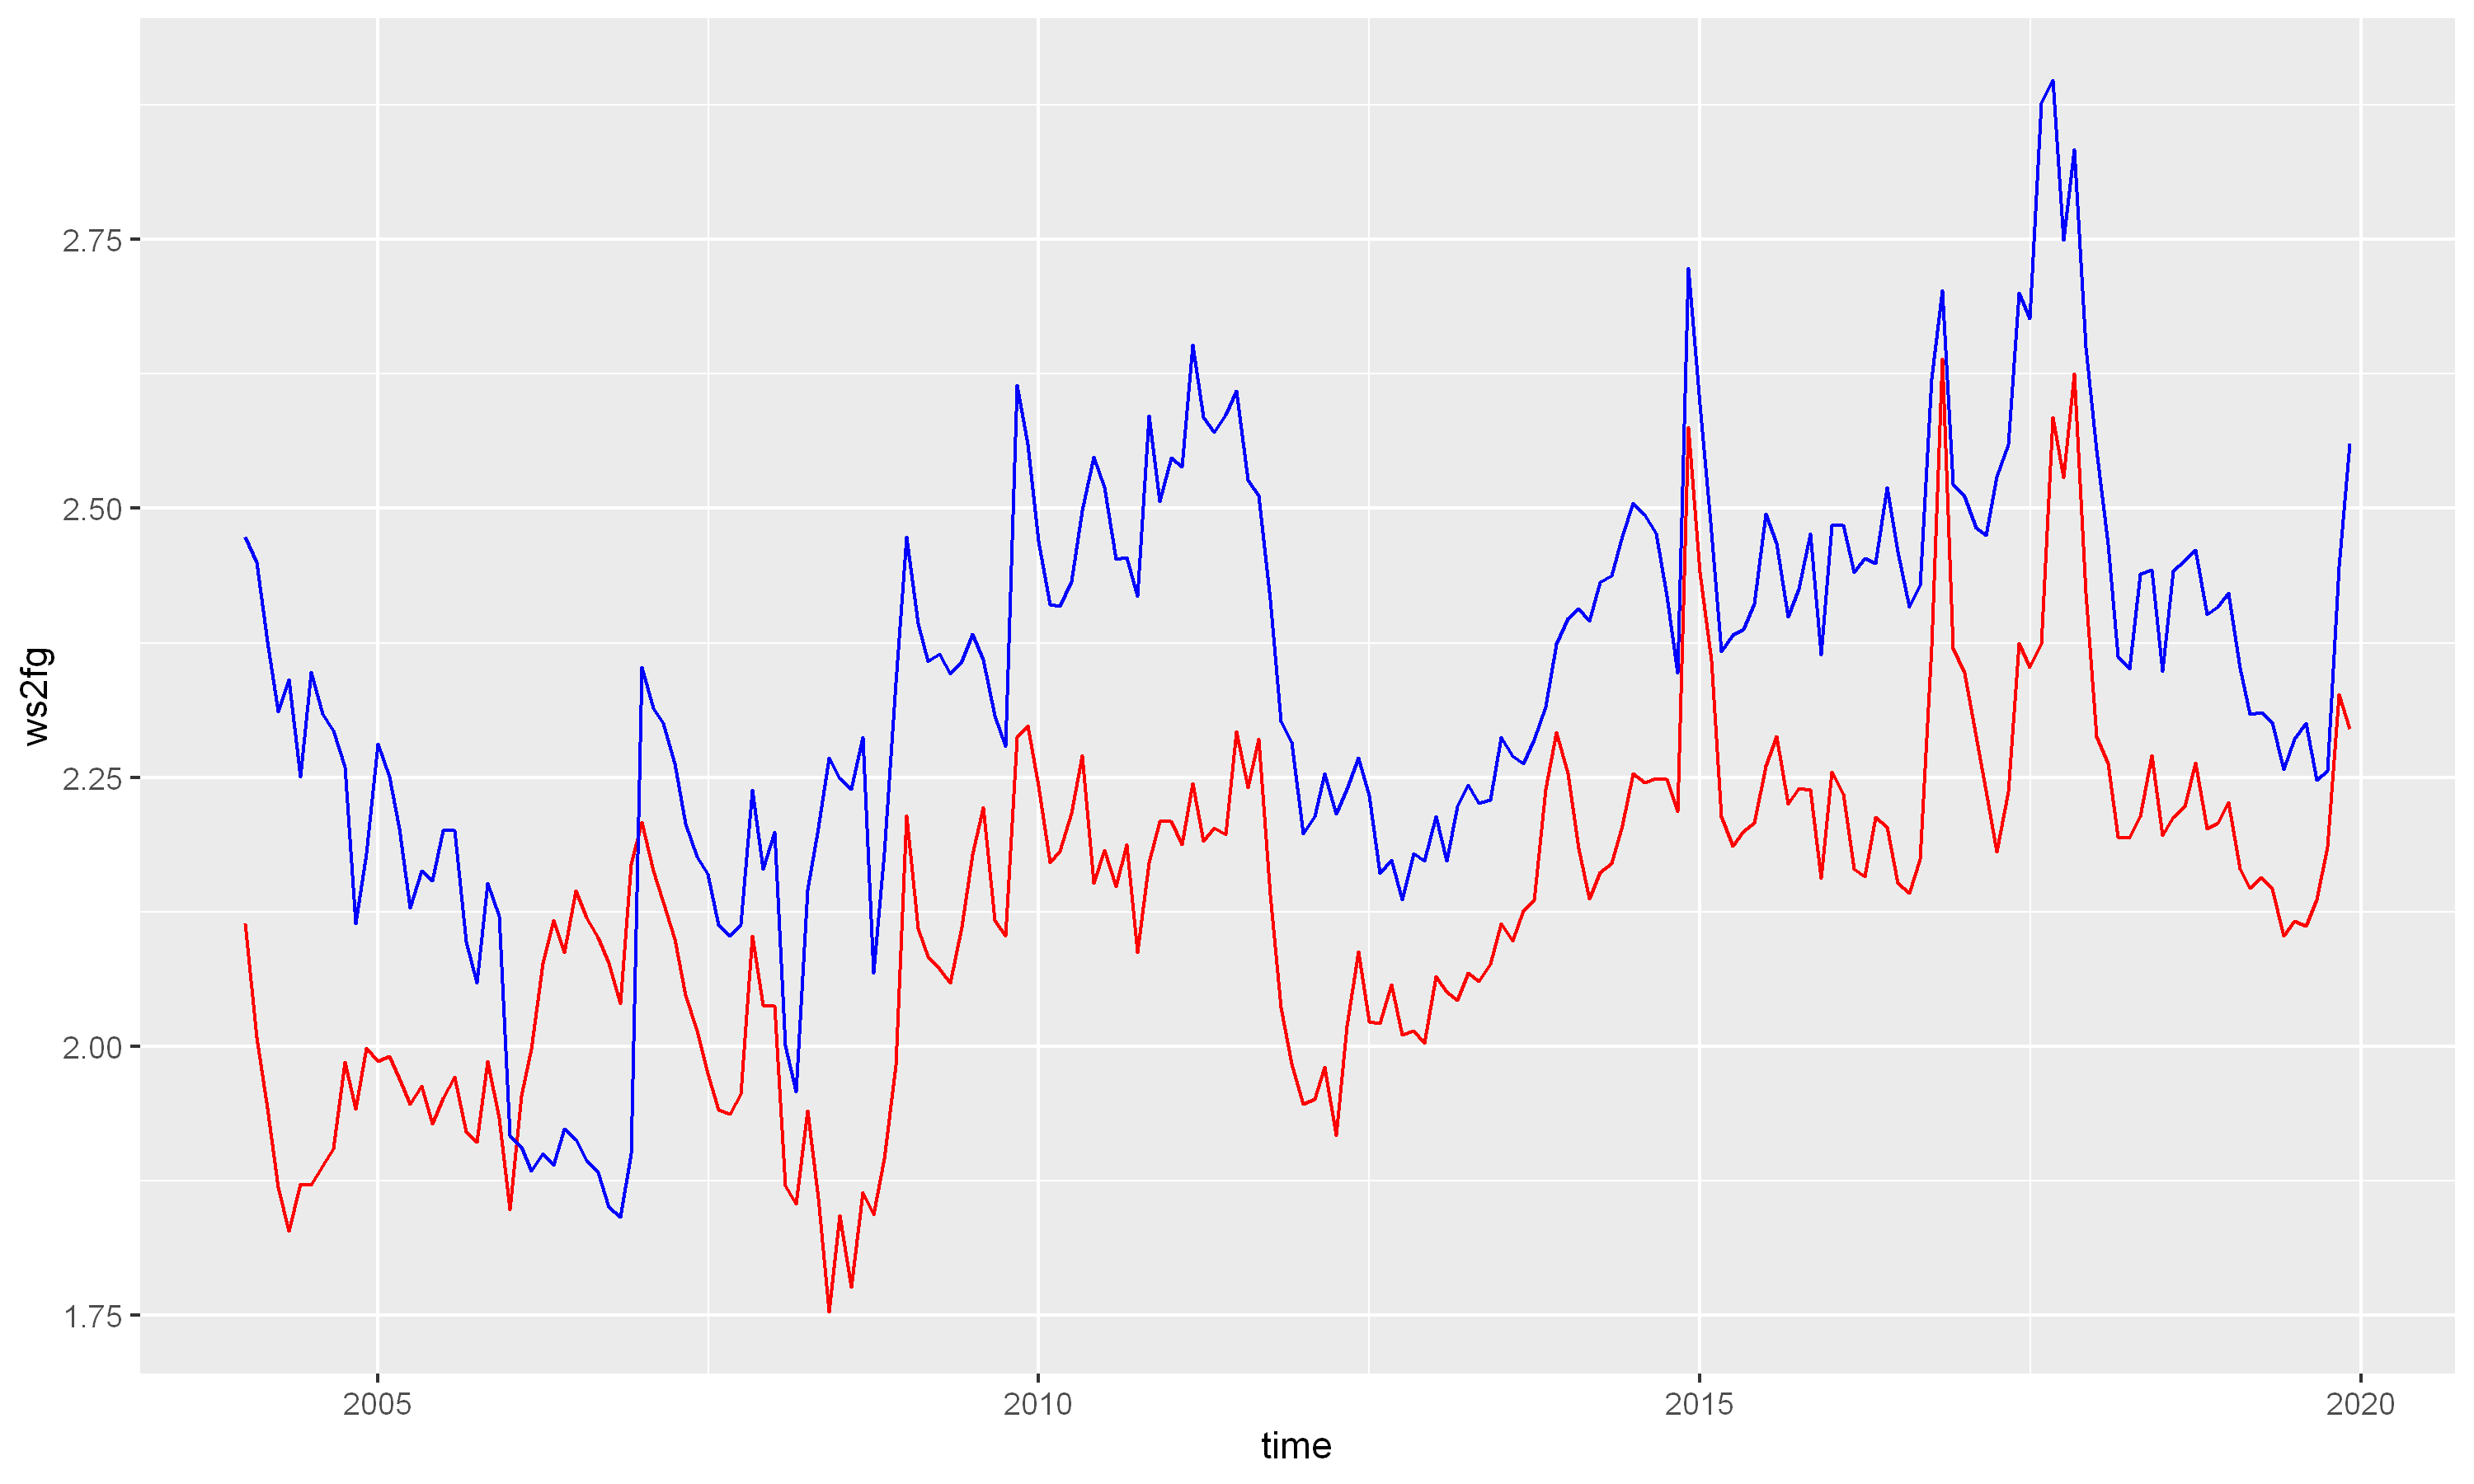

In [184]:
ggplot(x, aes(x = time, y = ws2fg)) +
  geom_line(color = "red") +
  geom_line(aes(x = time, y = xb2fg), color = "blue")

In [187]:
x %>%
  filter(rhws > rhxb)

time,rhfg,rhws,rhxb,d_foodcrisis,d_pledge,ws2fg,xb2fg,xb2ws
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2006-02-01,7873,15384.21,15007.82,1,1,1.954047,1.906239,0.9755340
2006-03-01,7960,15900.00,14998.42,1,1,1.997487,1.884224,0.9432970
2006-04-01,8028,16677.27,15255.81,1,1,2.077388,1.900325,0.9147663
2006-05-01,8069,17085.53,15243.53,1,1,2.117428,1.889148,0.8921899
2006-06-01,8160,17032.89,15694.92,1,1,2.087365,1.923397,0.9214476
...,...,...,...,...,...,...,...,...
2006-08-01,8612,18250.00,16309.69,1,1,2.119136,1.893833,0.8936815
2006-09-01,8642,18160.00,16268.91,1,1,2.101365,1.882540,0.8958650
2006-10-01,8685,18042.86,16071.15,1,1,2.077473,1.850449,0.8907208


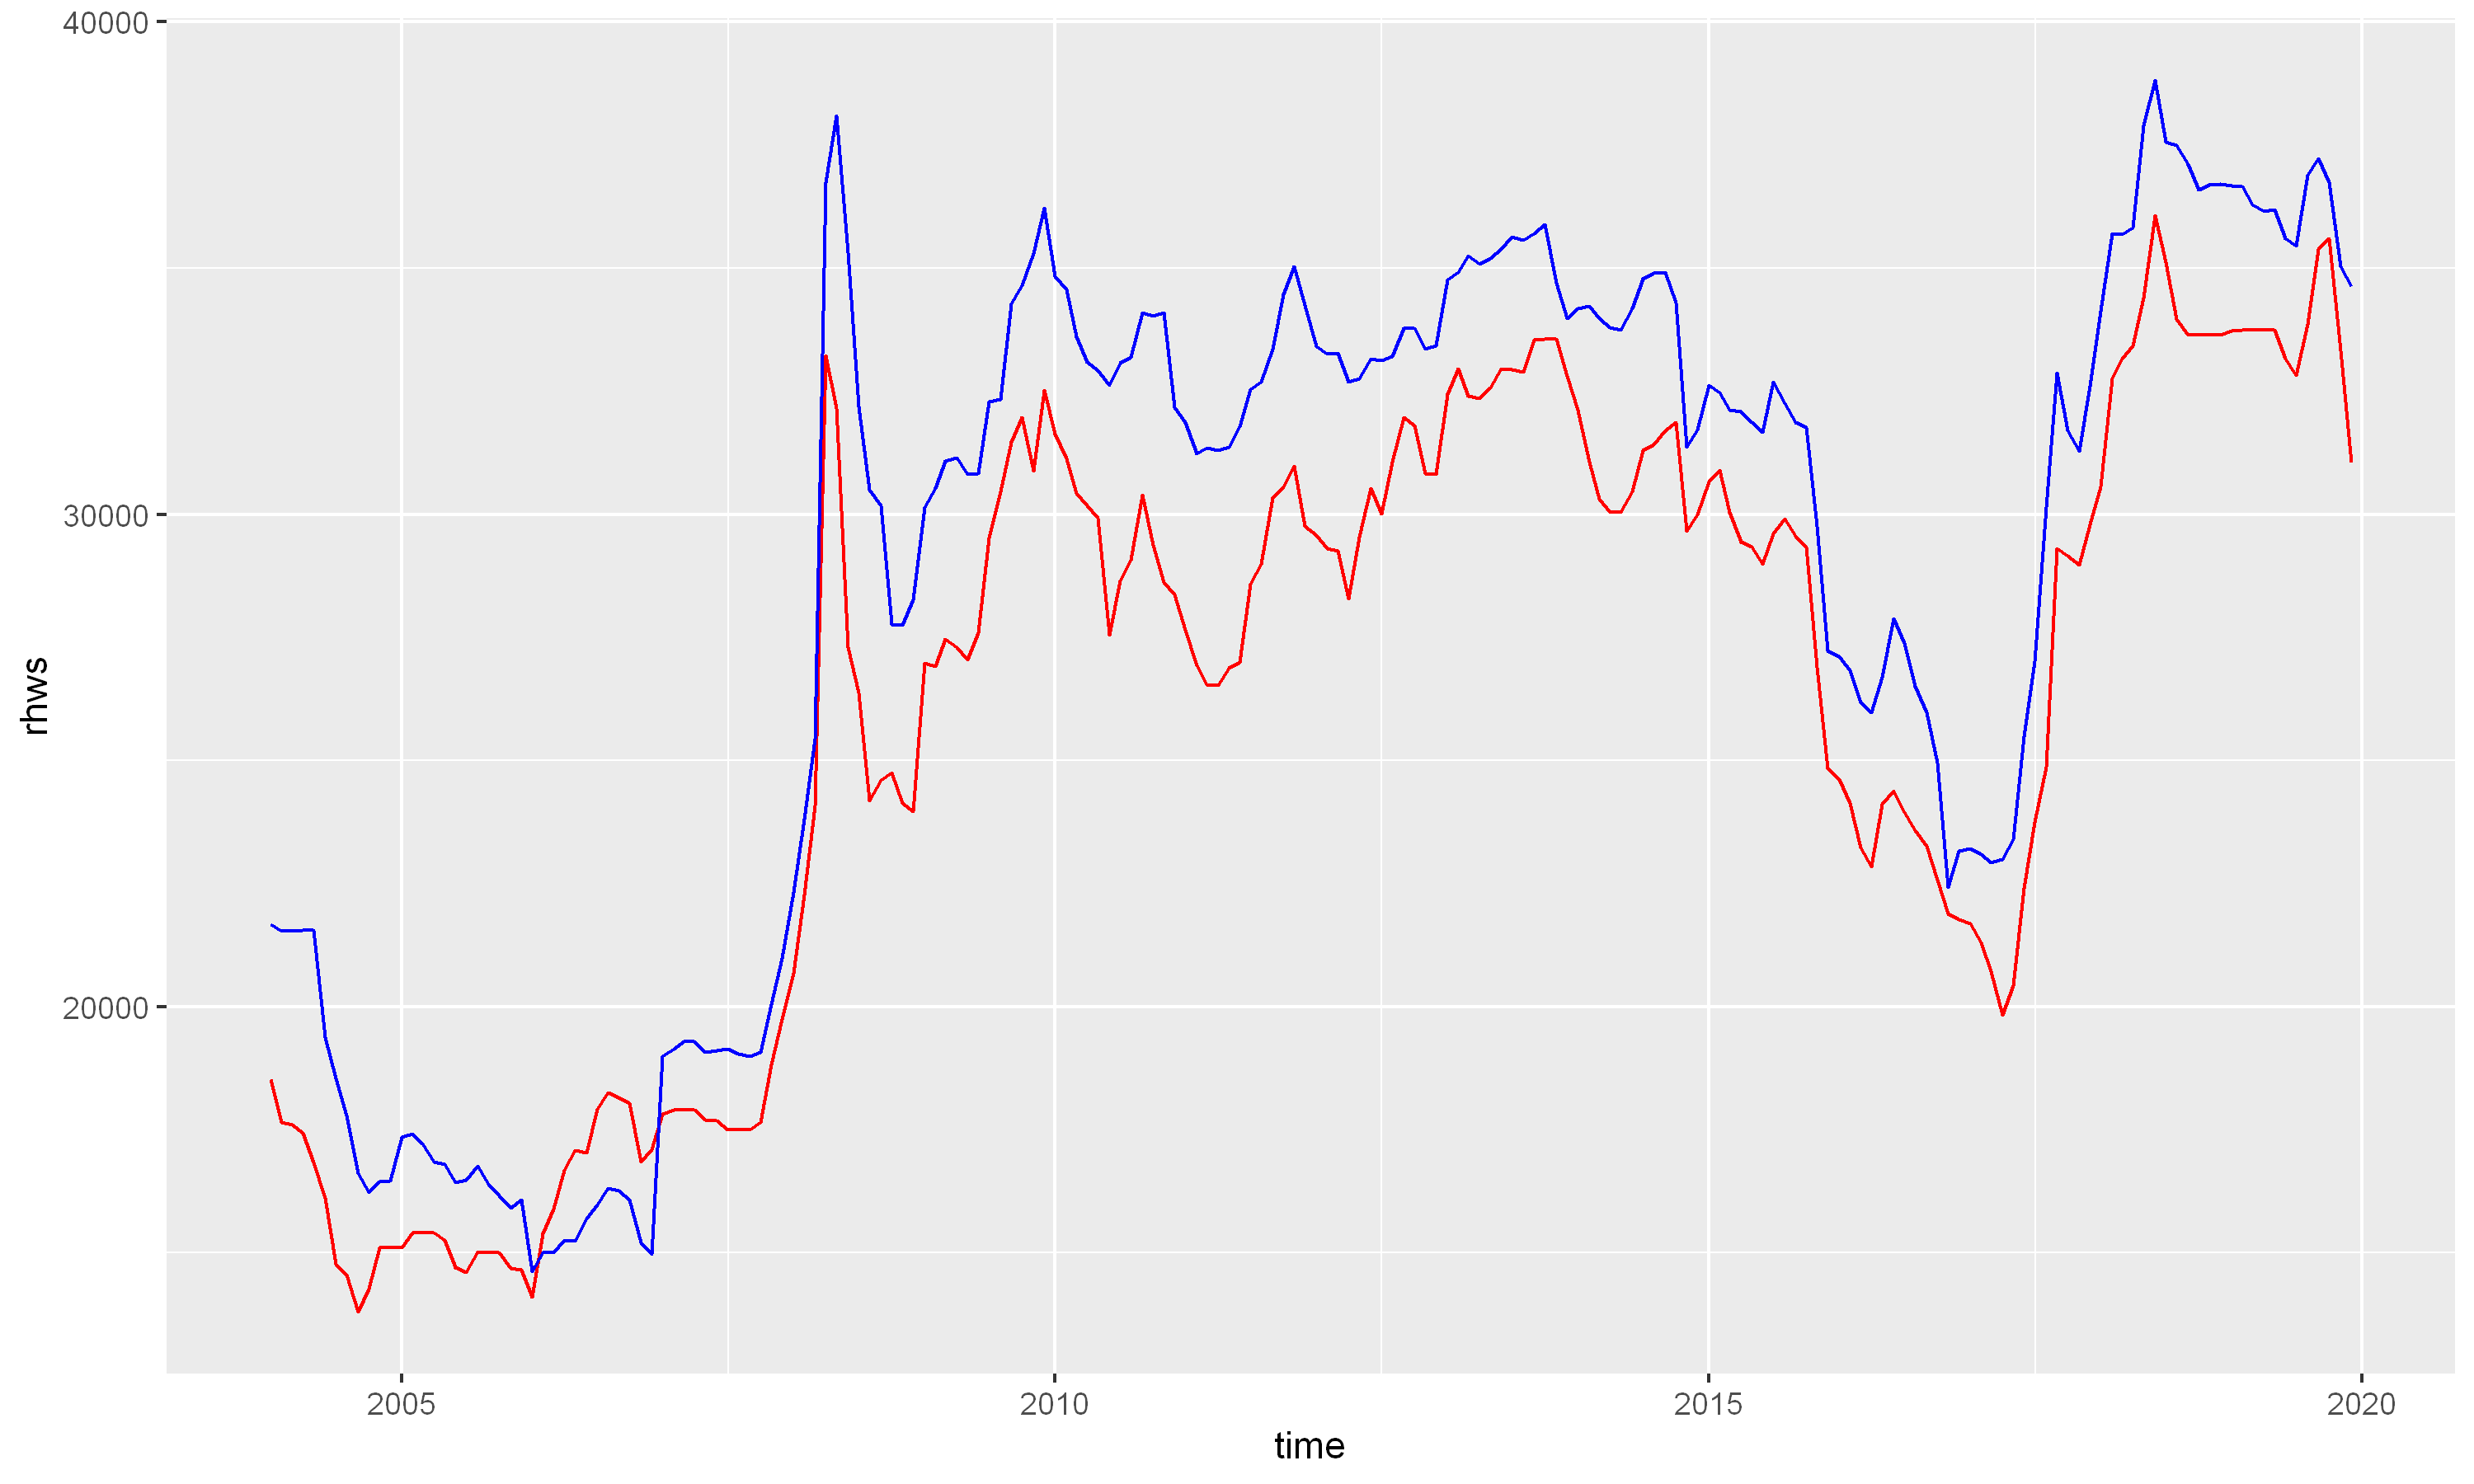

In [186]:
ggplot(x, aes(x = time, y = rhws)) +
  geom_line(color = "red") +
  geom_line(aes(x = time, y = rhxb), color = "blue")

# Unit Root Test

In [86]:
# get object name as a string
get_objname <- function(x) deparse(substitute(x))

# unit root test for a time series
tsf_ur_adf <- function(y, n_diff = 0, varname = NULL, ...) {
  
  varname <- if (is.null(varname)) deparse(substitute(y)) else varname
  y <- y %>% ts_ts
  y <- if(n_diff == 0) y else diff(y, n_diff)
  
  ur.trend <- ur.df(y, type='trend', lags = 10, selectlags = "BIC", ...)
  ur.drift <- ur.df(y, type='drift', lags = 10, selectlags = "BIC", ...)
  ur.none  <- ur.df(y, type='none' , lags = 10, selectlags = "BIC", ...)

  tstat.trend <- ur.trend@teststat
  tstat.drift <- ur.drift@teststat
  tstat.none  <- ur.none@teststat

  cv.trend <- ur.trend@cval
  cv.drift <- ur.drift@cval
  cv.none  <- ur.none@cval
  
  lags.trend <- dim(ur.trend@testreg$coefficients)[1] - 3
  lags.drift <- dim(ur.drift@testreg$coefficients)[1] - 2
  lags.none  <- dim(ur.none@testreg$coefficients)[1]  - 1

  df_test <- rbind(
    cbind(t(tstat.trend), cv.trend, lags.trend),
    cbind(t(tstat.drift), cv.drift, lags.drift),
    cbind(t(tstat.none) , cv.none , lags.none)
  ) %>% 
    as.data.frame() %>%
    rename(c("lag" = "lags.trend")) %>%
    rownames_to_column("hypo") %>%
    filter(str_starts(hypo, 'tau')) %>%
    mutate(
      result = ifelse(abs(statistic) >= abs(`5pct`), 'Reject', 'Accept'),
      variable = varname,
      level = paste0('d', n_diff),
      star = case_when(
        abs(statistic) > abs(`1pct`) ~ "***",
        abs(statistic) > abs(`5pct`) ~ "** ",
        abs(statistic) > abs(`10pct`) ~ "*  ",
        TRUE ~ "   "
      ),
      hypo = case_when(
        hypo == "tau3" ~ "trend",
        hypo == "tau2" ~ "constant",
        hypo == "tau1" ~ "none"
      ),
      statistic = format(round(statistic, 3), nsmall = 3) %>% 
        as.character %>% str_pad(6, "left")
    ) %>%
    select(variable, hypo, level, everything())
  
  return(df_test)
}

In [87]:
# unit root test in a table format
tsf_report_adf <- function(adf_test) {
  adf_test %>% 
    mutate(
      stat_star = glue::glue(
        "{statistic}{star}({lag})"
      ) %>% as.character()
    ) %>%
    pivot_wider(
      id_cols = c("variable"),
      names_from = c("level", "hypo"),
      values_from = c("stat_star")
    )
}

In [88]:
rh_names <- c('RHFG', 'RHWS', 'RHXB')
rw_names <- c('RWFG', 'RWWS', 'RWXB')

params_rh <- expand_grid(rh_names, c(0,1)) %>%
  set_names(c('name', 'ndiff')) %>%
  mutate(ser = rh[, name] %>% as.list)

params_rw <- expand_grid(rw_names, c(0,1)) %>%
  set_names(c('name', 'ndiff')) %>%
  mutate(ser = rw[, name] %>% as.list)

params <- rbind(params_rh, params_rw)

In [47]:
library(psych)
s1 <- describe(x$rh$endo %>% exp %>% ts_wide) %>% as_tibble()
s2 <- describe(x$rw$endo %>% exp %>% ts_wide) %>% as_tibble()
s0 <- bind_rows(s1, s2) %>% select(mean, sd, min, max)
s0 %>% round(0)

mean,sd,min,max
<dbl>,<dbl>,<dbl>,<dbl>
12208,2870,7186,17292
26051,6493,13795,36069
28675,7261,14622,38815
8089,1524,5000,13259
13481,2880,8735,26057
14455,3611,8403,30996


# Steps

## Overall Procedure
1. Model Specification
  - Unit Root Test -> `urca::ur.df`
  - AR Order or Lag Selection -> `VARselect`
  - Functional Form -> `tsDyn::VECM` and `AIC`, `BIC`
  - Cointegrating Rank -> `tsDyn::rank.test`
  - Choice of Deterministic Term
    - exos + seasonal 

2. Model Checking
  - Descriptive Analysis
  - Diagnostic Tests
    * Serial Autocorrelation
    * Heteroskedasticity
    * Normality
    * Stability
    
3. Analysis
  - Interpret
  - Test economic theory
  - Granger Causality
  - IRF

## Toda Yamamoto Procedure
1. Stationary test and find maximum order of integration called `m`
2. Determine optimal lag of VAR in levels using information criteria called `p`
3. Given lag `p` estimate VAR(p) and test for serial correlation. If failed to pass add more lag until there is no serial correlation problem.
4. Conduct a cointegration test i.e. Johansen test keep result for cross-checking
5. Estimate VAR(p+m)
6. Wald test of the first `p` lags not `p+m` and associated test statistics is distributed as Chi-square(p)

# Vertical PT: Hommali Rice

In [125]:
endo <- x$rh$endo
exo <- x$rh$exo

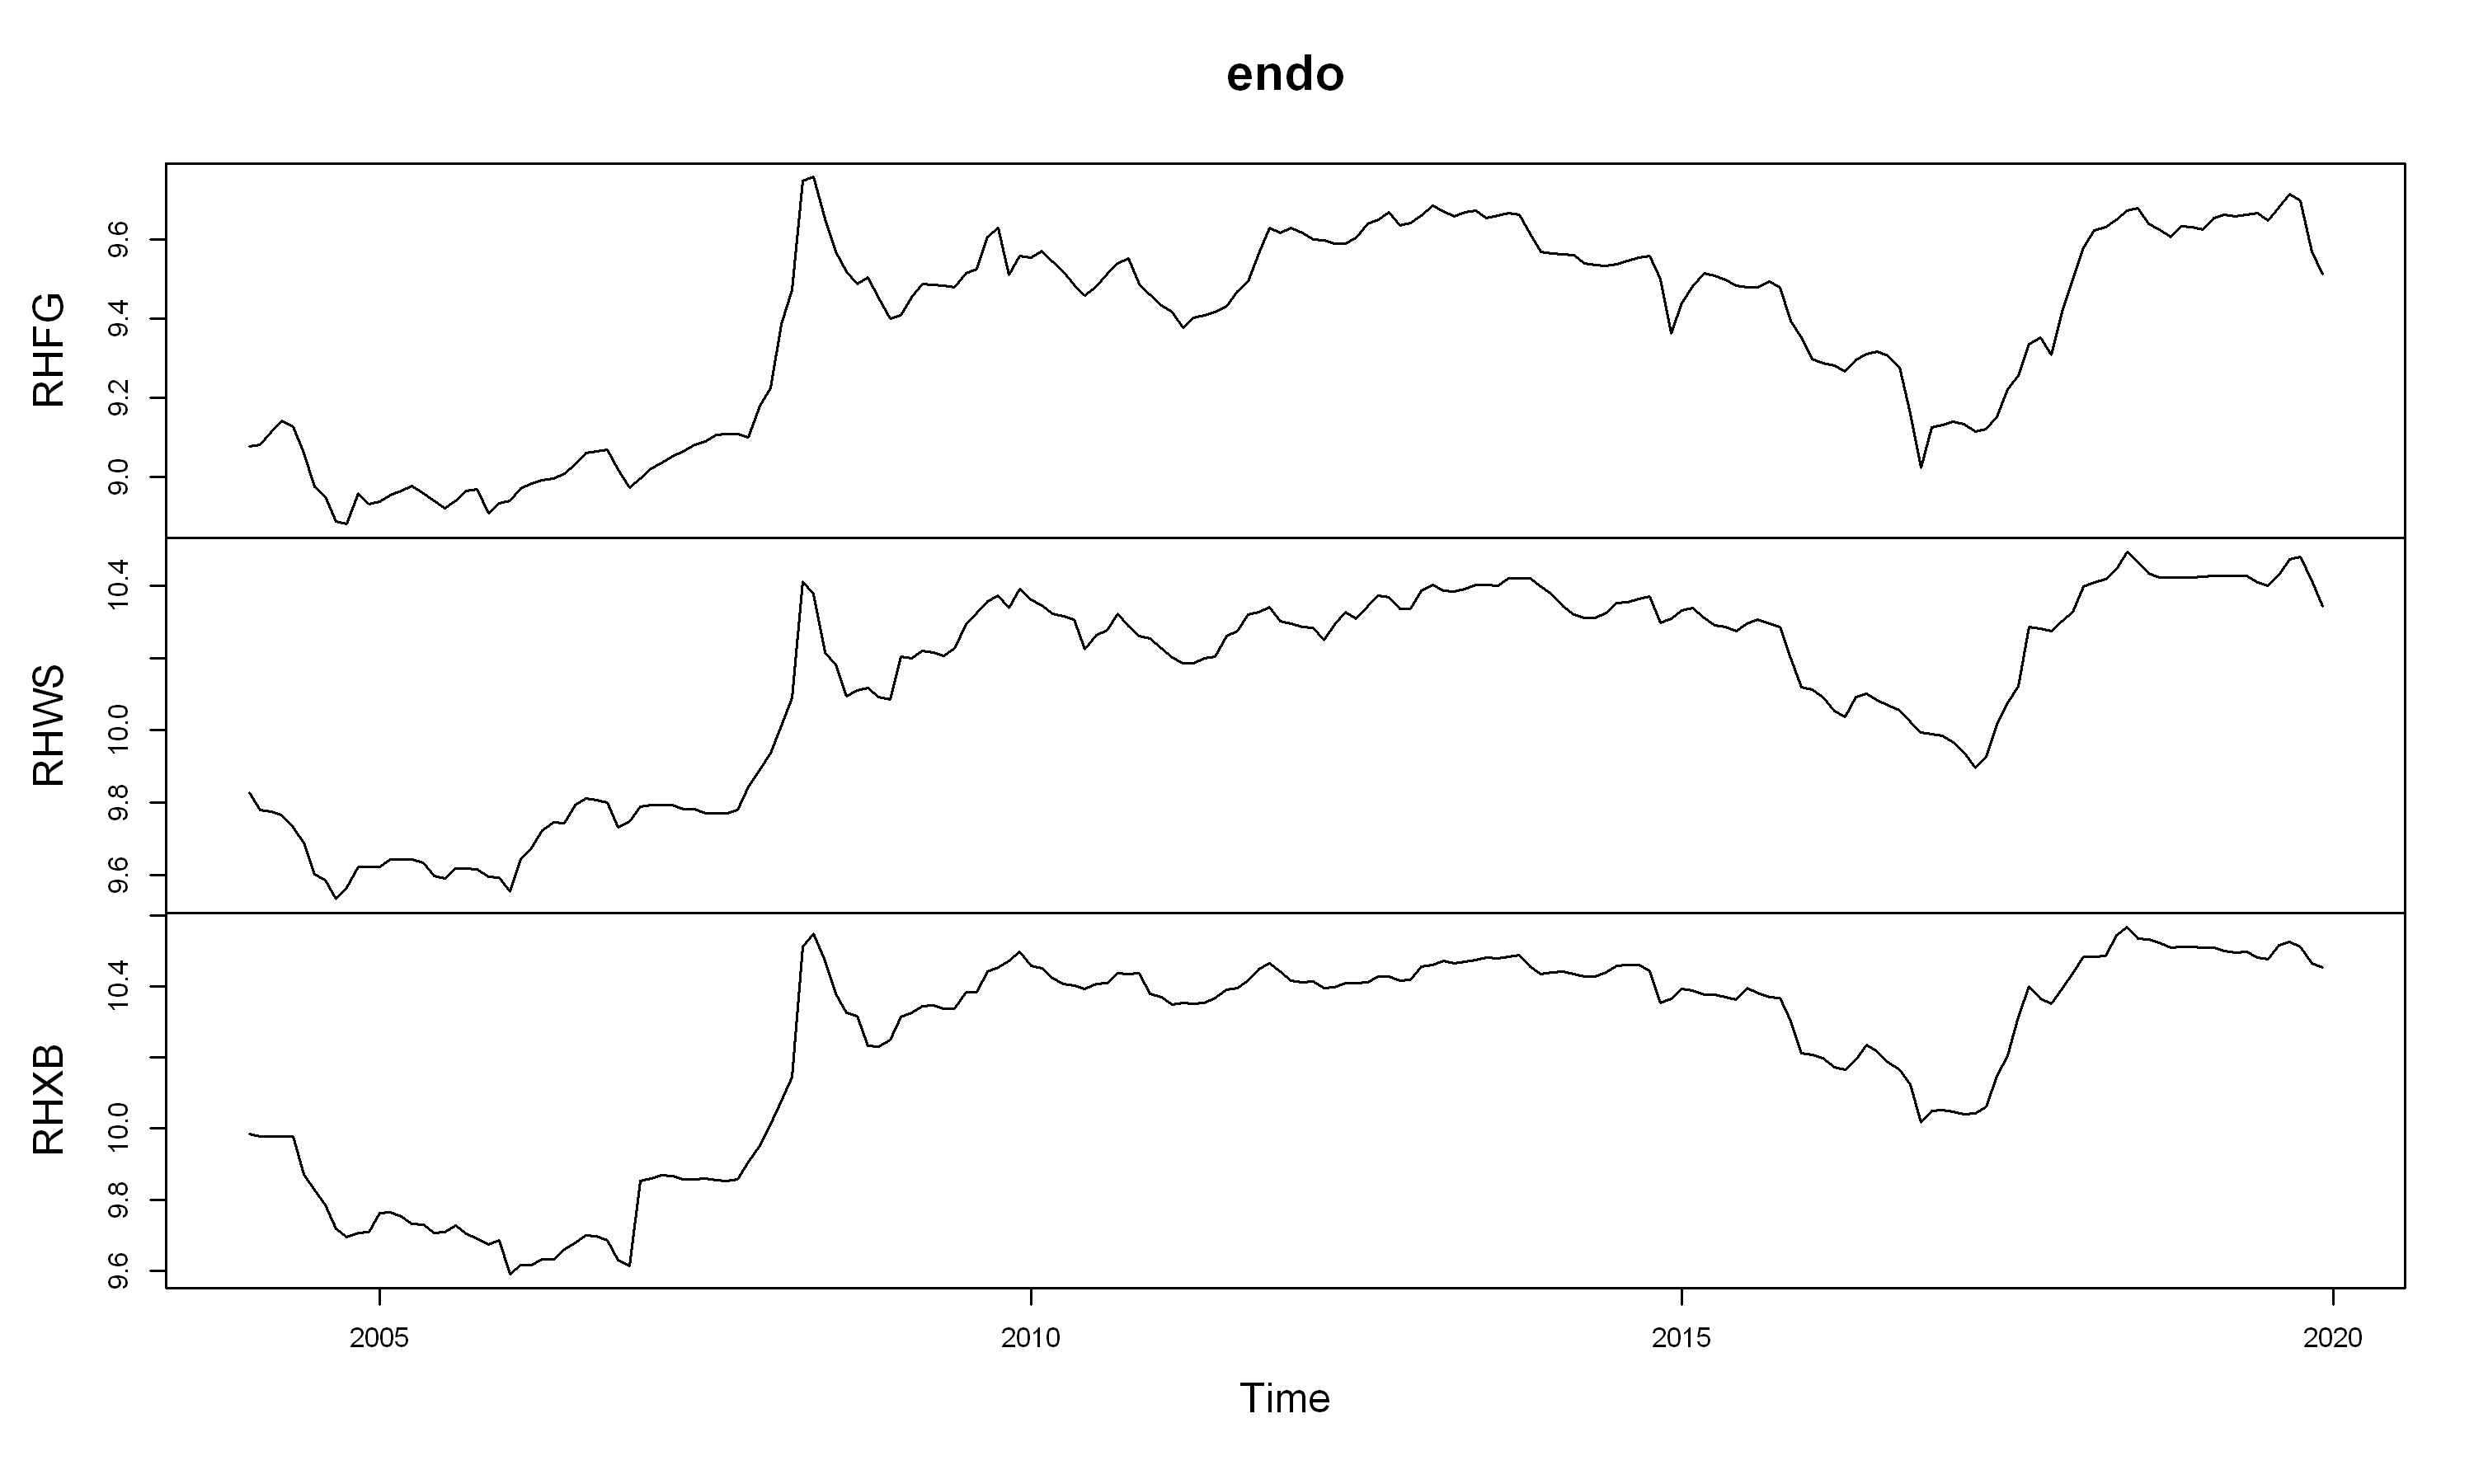

In [126]:
plot(endo)

## Model Specification

### Lag Selection

In [114]:
VARselect(endo, lag.max = 5, type = 'const')$criteria %>% t

,AIC(n),HQ(n),SC(n),FPE(n)
1,-20.32715,-20.24313,-20.11980,1.486075e-09
2,-20.43946,-20.29243,-20.07661,1.328314e-09
3,-20.40355,-20.19351,-19.88519,1.377154e-09
4,-20.34362,-20.07057,-19.66976,1.462748e-09
5,-20.27947,-19.94341,-19.45010,1.560573e-09


In [115]:
VARselect(endo, lag.max = 5, type = 'both')

,1,2,3,4,5
AIC(n),-2.034445e+01,-2.044649e+01,-2.040780e+01,-2.034480e+01,-2.027924e+01
HQ(n),-2.023943e+01,-2.027846e+01,-2.017676e+01,-2.005075e+01,-1.992217e+01
SC(n),-2.008527e+01,-2.003180e+01,-1.983761e+01,-1.961910e+01,-1.939803e+01
FPE(n),1.460609e-09,1.319075e-09,1.371450e-09,1.461266e-09,1.561331e-09


In [113]:
VARselect(endo, lag.max = 5, type = 'both')$criteria %>% t %>% 
  as_tibble() %>% janitor::clean_names() %>%
  select(4,1,3,2) %>%
  write_xlsx('results/02_lag_select_rh.xlsx')

In [130]:
check_VAR <- function(var_obj) {
  res <- list()
  res$serial <- serial.test(var_obj, lags.pt = 12, type = 'PT.asymptotic')
  res$arch   <- arch.test(var_obj, lags.multi = 12)
  res$norm   <- normality.test(var_obj)
  return(res)
}

VAR(endo, p = 1, type = "both") %>% check_VAR()

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_obj
Chi-squared = 102.63, df = 99, p-value = 0.3811


$arch

	ARCH (multivariate)

data:  Residuals of VAR object var_obj
Chi-squared = 498.55, df = 432, p-value = 0.01464


$norm
$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_obj
Chi-squared = 2115.5, df = 6, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_obj
Chi-squared = 183.56, df = 3, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_obj
Chi-squared = 1932, df = 3, p-value < 2.2e-16




> **optimal lag** = 1

### Deterministic Terms

In [182]:
x <- VECM(Canada, lag = 2, estim = "ML", include = 'both',  LRinclude = 'both')
rank.test(x)

ERROR: Error in rank.test(x): Sorry, rank.test does not work for model selected (due to specification of deterministic terms)



In [149]:
select_DT <- function(endo, exo) {
  spec1 <- VECM(endo, lag = 1, estim = "ML", include = 'none',  LRinclude = 'none' , exogen = exo)
  spec2 <- VECM(endo, lag = 1, estim = "ML", include = 'none',  LRinclude = 'const', exogen = exo)
  spec3 <- VECM(endo, lag = 1, estim = "ML", include = 'const', LRinclude = 'const', exogen = exo)
  spec4 <- VECM(endo, lag = 1, estim = "ML", include = 'const', LRinclude = 'trend', exogen = exo)
  spec5 <- VECM(endo, lag = 1, estim = "ML", include = 'trend', LRinclude = 'both' , exogen = exo)
#   spec6 <- VECM(endo, lag = 1, estim = "ML", include = 'none',  LRinclude = 'trend' , exogen = exo)
  
  res <- list(spec1, spec2, spec3, spec4, spec5)
  tibble(
    model = 1:length(res),
    AIC = res %>% map_dbl(AIC),
    BIC = res %>% map_dbl(BIC)
  ) %>% arrange(BIC)
}

select_DT(endo, exo = exo)

model,AIC,BIC
<int>,<dbl>,<dbl>
5,-3902.807,-3837.866
2,-3897.585,-3832.645
3,-3897.585,-3832.645
1,-3894.527,-3829.586
4,-3897.223,-3822.542


In [156]:
x <- VECM(endo, lag = 1, estim = "ML", include = 'none',  LRinclude = 'const', exogen = exo)
rank.test(x) %>% summary() #%>% 
#   write_xlsx('results/rh_03_rank_test.xlsx')

r,trace,trace_pval,trace_pval_T,eigen,eigen_pval
<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>
0,47.590974,0.001091,0.001195,28.170039,0.004998
1,19.420936,0.063756,0.065940,16.588033,0.036547
2,2.832903,0.619524,< 0.001,2.832903,0.618373


In [158]:
x %>% summary()

Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"


#############
###Model VECM 
#############
Full sample size: 192 	End sample size: 190
Number of variables: 3 	Number of estimated slope parameters 18
AIC -3897.585 	BIC -3832.645 	SSR 0.9509125
Cointegrating vector (estimated by ML):
   RHFG      RHWS        RHXB     const
r1    1 -0.779111 -0.05468003 -0.903613


              ECT                 RHFG -1            RHWS -1           
Equation RHFG -0.2247(0.0529)***  0.0966(0.0967)     0.1981(0.1182).   
Equation RHWS -0.0481(0.0559)     0.0339(0.1022)     0.1460(0.1249)    
Equation RHXB -0.1234(0.0546)*    0.0224(0.0998)     0.2233(0.1220).   
              RHXB -1             d_foodcrisis      d_pledge          
Equation RHFG 0.0419(0.1091)      0.0722(0.0199)*** 0.0204(0.0088)*   
Equation RHWS 0.0469(0.1152)      0.0377(0.0210).   0.0042(0.0093)    
Equation RHXB -0.0370(0.1126)     0.0826(0.0205)*** 0.0106(0.0090)    

In [150]:
vecm_selected <- VECM(endo, lag = 1, estim = "ML", include = 'const', LRinclude = 'trend' , exogen = exo)
rank.test(vecm_selected)

Rank selected: 1 (first eigen test with pval above 5 %: 7.7 %)

In [142]:
vecm_est <- VECM(endo, lag = 1, r = 2, estim = "ML", include = 'const', LRinclude = 'both', exogen = exo)

In [143]:
vecm_est %>% summary()

Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "numeric") return(noquote(r)):
"the condition has length > 1 and only the first element will be used"
Warning message in if (class(x) == "matrix") return(matrix(noquote(r), ncol = ncol(x), :
"the condition has length > 1 and only the first element will be used"


#############
###Model VECM 
#############
Full sample size: 195 	End sample size: 193
Number of variables: 3 	Number of estimated slope parameters 21
AIC 7492.307 	BIC 7567.349 	SSR 541083109
Cointegrating vector (estimated by ML):
   RHFG RHWS       RHXB     const     trend
r1    1    0 -0.3635126 -1911.142  3.602570
r2    0    1 -0.8239831 -2017.074 -4.720985


              ECT1                ECT2                RHFG -1           
Equation RHFG -0.2918(0.0647)***  0.0696(0.0372).     0.1209(0.1036)    
Equation RHWS -0.1123(0.1437)     -0.0533(0.0827)     0.0563(0.2301)    
Equation RHXB -0.2115(0.1449)     0.1693(0.0834)*     0.1250(0.2321)    
              RHWS -1            RHXB -1            d_foodcrisis          
Equation RHFG 0.0820(0.0622)     0.0115(0.0560)     971.5937(254.8224)*** 
Equation RHWS 0.1271(0.1382)     0.0619(0.1244)     864.1697(565.7729)    
Equation RHXB 0.1157(0.1394)     0.0409(0.1254)     2093.0477(570.7214)***
              d_pledge              
Equa

In [141]:
vecm_est$model.specific$beta

,r1,r2
RHFG,1.0000000,0.0000000
RHWS,0.0000000,1.0000000
RHXB,-0.3406024,-0.8563922


In [ ]:
var.rh <- VAR(endo, lag.max = 4, type = 'const', exogen = exo)

In [359]:
vecm_rh.trace <- ca.jo(
  x$rh$endo, type = 'trace', ecdet = 'const', K = 2,
  spec = 'transitory', dumvar = x$rh$exo, season = 12
)

vecm_rh.eigen <- ca.jo(
  x$rh$endo, type = 'eigen', ecdet = 'const', K = 2, 
  spec = 'transitory', dumvar = x$rh$exo, season = 12
)

summary(vecm_rh.trace)
summary(vecm_rh.eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 1.275686e-01 8.003480e-02 1.523741e-02 8.862396e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  2.92  7.52  9.24 12.97
r <= 1 | 18.77 17.85 19.96 24.60
r = 0  | 44.70 32.00 34.91 41.07

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              RHFG.l1   RHWS.l1    RHXB.l1    constant
RHFG.l1   1.000000000  1.000000  1.0000000  1.00000000
RHWS.l1  -0.842871039  2.491234  0.3264489 -1.32286278
RHXB.l1   0.004011214 -3.032640 -2.5249503 -0.02094209
constant -0.858170083 -3.602454 13.2365587  3.81957874

Weights W:
(This is the loading matrix)

           RHFG.l1      RHWS.l1     RHXB.l1     constant
RHFG.d -0.20719962 -0.017292471 0.005807340 2.852033e-14
RHWS.d -0.04733086 -0.007630187 0.011847608 6.074697e-15
RHXB.d 


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 1.275686e-01 8.003480e-02 1.523741e-02 8.862396e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  2.92  7.52  9.24 12.97
r <= 1 | 15.85 13.75 15.67 20.20
r = 0  | 25.93 19.77 22.00 26.81

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              RHFG.l1   RHWS.l1    RHXB.l1    constant
RHFG.l1   1.000000000  1.000000  1.0000000  1.00000000
RHWS.l1  -0.842871039  2.491234  0.3264489 -1.32286278
RHXB.l1   0.004011214 -3.032640 -2.5249503 -0.02094209
constant -0.858170083 -3.602454 13.2365587  3.81957874

Weights W:
(This is the loading matrix)

           RHFG.l1      RHWS.l1     RHXB.l1     constant
RHFG.d -0.20719962 -0.017292471 0.005807340 2.852033e-14
RHWS.d -0.04733086 -0.007630187 0.0118

> r = 2

In [357]:
beta <- vecm_rh.trace@V
beta[, 2] <- beta[, 2] / beta[2,2]
beta[, 3] <- beta[, 3] / beta[3,3]
beta

,RHFG.l1,RHWS.l1,RHXB.l1,constant
RHFG.l1,1.000000000,0.4014074,-0.3960474,1.00000000
RHWS.l1,-0.842871039,1.0000000,-0.1292892,-1.32286278
RHXB.l1,0.004011214,-1.2173242,1.0000000,-0.02094209
constant,-0.858170083,-1.4460518,-5.2423046,3.81957874


In [253]:
# tsDyn::VECM(endo, r = 2, lag = 1, exogen = exo, estim = "ML") %>% str

In [362]:
vecm_rh <- cajorls(vecm_rh.trace, r = 2)
vecm_rh$rlm %>% summary

Response RHFG.d :

Call:
lm(formula = RHFG.d ~ ect1 + ect2 + d_foodcrisis + d_pledge + 
    sd1 + sd2 + sd3 + sd4 + sd5 + sd6 + sd7 + sd8 + sd9 + sd10 + 
    sd11 + RHFG.dl1 + RHWS.dl1 + RHXB.dl1 - 1, data = data.mat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.120699 -0.014572 -0.000512  0.016100  0.197733 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
ect1         -0.224492   0.054271  -4.136 5.51e-05 ***
ect2          0.131563   0.058410   2.252  0.02556 *  
d_foodcrisis  0.070132   0.019533   3.590  0.00043 ***
d_pledge      0.022111   0.008765   2.523  0.01255 *  
sd1           0.004717   0.014116   0.334  0.73867    
sd2           0.017084   0.014404   1.186  0.23724    
sd3           0.003712   0.014632   0.254  0.80004    
sd4           0.016891   0.014262   1.184  0.23789    
sd5          -0.002529   0.014411  -0.176  0.86088    
sd6          -0.009436   0.014081  -0.670  0.50366    
sd7           0.005652   0.014076   0.401  0.688

In [352]:
vecm_rh

$rlm

Call:
lm(formula = substitute(form1), data = data.mat)

Coefficients:
              RHFG.d      RHWS.d      RHXB.d    
ect1          -2.245e-01  -5.496e-02  -8.552e-02
ect2           1.316e-01   2.089e-02   1.750e-01
d_foodcrisis   7.013e-02   3.897e-02   7.463e-02
d_pledge       2.211e-02   5.817e-03   5.762e-03
sd1            4.717e-03   8.736e-03   1.670e-02
sd2            1.708e-02   4.118e-03  -6.023e-04
sd3            3.712e-03  -5.911e-03  -4.708e-03
sd4            1.689e-02   1.336e-02   1.805e-02
sd5           -2.529e-03   1.423e-03   2.652e-03
sd6           -9.436e-03  -1.014e-02  -3.100e-03
sd7            5.652e-03   9.803e-03   7.455e-03
sd8            9.332e-03   4.647e-03   4.499e-03
sd9            1.286e-02   1.926e-02   6.091e-03
sd10          -4.672e-03  -3.661e-03  -1.701e-02
sd11          -4.273e-02  -1.954e-02  -2.242e-02
RHFG.dl1       8.891e-02   3.578e-02   1.704e-02
RHWS.dl1       2.914e-01   1.926e-01   2.376e-01
RHXB.dl1      -4.976e-02  -2.638e-05  -4.9

In [332]:
# vecm_rh$rlm %>% summary

In [334]:
21664.70*0.76

[1] 16465.17

In [333]:
21664.70*0.9107844

[1] 19731.87

In [329]:
endo

,RHFG,RHWS,RHXB
Jan 2004,8759,18515.79,21664.70
Feb 2004,8791,17655.00,21533.90
Mar 2004,9062,17600.00,21532.68
Apr 2004,9329,17435.29,21557.25
May 2004,9209,16835.00,21557.97
Jun 2004,8607,16109.52,19370.70
Jul 2004,7894,14768.18,18534.98
Aug 2004,7704,14550.00,17786.70
Sep 2004,7243,13795.45,16609.91
Oct 2004,7186,14267.50,16235.60


In [328]:
1.55/0.76

[1] 2.039474

In [325]:
vecm_rh$beta %>% as.data.frame

,ect1,ect2
,<dbl>,<dbl>
RHFG.l2,1.0000000,0.0000000
RHWS.l2,0.0000000,1.0000000
RHXB.l2,-0.7636625,-0.9107844
constant,-1.5519326,-0.8230945


In [315]:
data(Canada)
vecm.x <- ca.jo(Canada)
var.x <- vec2var(vecm.x)

In [316]:
var.x$A

,e.l1,prod.l1,rw.l1,U.l1
e,1.7788626,0.16712385,-0.02687009,0.1899173
prod,-0.2319289,1.15792013,0.10678987,-0.6027117
rw,-0.3779577,-0.07103645,0.98783225,-0.2213936
U,-0.6284347,-0.07967735,-0.01829959,0.7085469
,e.l2,prod.l2,rw.l2,U.l2
e,-0.7656226,-0.16513409,0.02360625,-0.1420834
prod,0.2985711,-0.14790495,-0.12321796,0.8434771
rw,0.1962418,0.04372764,0.05696290,-0.4351112
U,0.5845949,0.07308898,0.02910662,0.1330683


## Model Checking

In [319]:
Mod(eigen(diag(3) - var_rh$A$A1 - var_rh$A$A2)$values)

[1] 2.188264e-01 1.371673e-01 2.775558e-17

In [305]:
var_rh <- vec2var(vecm_rh.trace, r = 2)
serial1 <- serial.test(var_rh, lags.pt = 12, type = 'PT.asymptotic')
arch1 <- arch.test(var_rh, lags.multi = 12)
norm1 <- normality.test(var_rh)

serial1$serial
arch1$arch.mul
norm1$jb.mul$JB


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_rh
Chi-squared = 90.506, df = 93, p-value = 0.5539



	ARCH (multivariate)

data:  Residuals of VAR object var_rh
Chi-squared = 470.91, df = 432, p-value = 0.09534



	JB-Test (multivariate)

data:  Residuals of VAR object var_rh
Chi-squared = 1529.6, df = 6, p-value < 2.2e-16


In [309]:
vec2var

[1] "vec2var"

In [297]:
eigen(var_rh$A$A1)$values

[1] 1.2112809 0.9066156 0.8169060

In [262]:
eigen(var_rh$A$A2)

eigen() decomposition
$values
[1] -0.2438592  0.0826742 -0.0445017

$vectors
           [,1]         [,2]       [,3]
[1,] -0.7634156 -0.008123018 -0.9443364
[2,] -0.4745422 -0.199792543  0.1920618
[3,] -0.4381852  0.979804550  0.2670974


## Analysis

### Granger

### IRF

### LOP

In [ ]:
H1 = ca.jo(
  x$rh$endo, type = 'trace', ecdet = 'const', K = 2, 
  spec = 'transitory', dumvar = x$rh$exo
)
H1 %>% summary()

In [ ]:
HA = matrix(c( 1, 0, 0,
               0, 1, 0,
              -1, 0, 0,
               0, 0, 1
             ), 
            ncol = 3, byrow = TRUE)

blrtest(z = vecm_rh.trace, H = HA, r = 1) %>% summary()

In [ ]:
save_irf_plot = function(model, impulse, width = 6, height = 8, n.ahead = 12) {
  model_name = deparse(substitute(model))
  filename = paste0("../img/irf_", model_name, '_', impulse, ".png")
  png(filename = filename,
    units = "in", 
    width = width, 
    height = height,
    pointsize = 10, 
    res = 300)
  plot(irf(model, impulse = impulse, n.ahead = n.ahead))
  dev.off()
}

In [ ]:
save_irf_plot(var_rh, 'RHFG')
save_irf_plot(var_rh, 'RHWS')
save_irf_plot(var_rh, 'RHXB')

In [ ]:
TVECM.HStest(endo[, c(1,3)])

In [ ]:
# TVECM(endo[, c(1,3)], common = 'only_ECT', include = 'const') %>% summary()

In [ ]:
# tsDyn::VECM(endo, lag = 1, r = 2, estim = "ML",
#             include = 'const', exogen = exo) %>% summary()

# Vertical : White Rice

In [116]:
endo <- x$rw$endo
exo <- x$rw$exo

In [ ]:
summary(endo %>% exp())

In [ ]:
# set_figsize(10, 6)
filename = paste0("../img/plot_", 'rhfg', ".png")
png(filename = filename,
  units = "in", 
  width = 12, 
  height = 6, 
  pointsize = 10, 
  res = 300)
plot.ts(endo)
dev.off()

## Model Specification

In [122]:
VARselect(endo, lag.max = 5, type = 'const')

,1,2,3,4,5
AIC(n),-2.107088e+01,-2.135922e+01,-2.138932e+01,-2.138413e+01,-2.133848e+01
HQ(n),-2.098686e+01,-2.121219e+01,-2.117928e+01,-2.111108e+01,-2.100242e+01
SC(n),-2.086353e+01,-2.099637e+01,-2.087096e+01,-2.071026e+01,-2.050911e+01
FPE(n),7.063862e-10,5.294862e-10,5.138896e-10,5.167528e-10,5.412035e-10


In [123]:
VARselect(endo, lag.max = 5, type = 'both')

,1,2,3,4,5
AIC(n),-2.119494e+01,-2.146083e+01,-2.145371e+01,-2.143900e+01,-2.139220e+01
HQ(n),-2.108992e+01,-2.129280e+01,-2.122267e+01,-2.114494e+01,-2.103514e+01
SC(n),-2.093576e+01,-2.104614e+01,-2.088351e+01,-2.071329e+01,-2.051099e+01
FPE(n),6.239780e-10,4.783520e-10,4.818919e-10,4.892461e-10,5.130266e-10


In [124]:
VARselect(endo, lag.max = 5, type = 'const')$criteria %>% t %>% 
  as_tibble() %>% janitor::clean_names() %>%
  select(4,1,3,2) %>%
  write_xlsx('results/02_lag_select_rw.xlsx')

In [ ]:
vecm.trace = ca.jo(
  endo, type = 'trace', ecdet = 'const', K = 2,
  spec = 'transitory', dumvar = exo
)

vecm.eigen = ca.jo(
  endo, type = 'eigen', ecdet = 'const', K = 2, 
  spec = 'transitory', dumvar = exo
)

summary(vecm.trace)
summary(vecm.eigen)

### Law of One Price

In [ ]:
HA = matrix(c( 1, 1, 1, 1,
              -1, 0, 0, 0,
               0,-1, 0, 0,
               0, 0,-1, 0,
               0, 0, 0,-1
             ), 
            ncol = 4, byrow = TRUE)

blrtest(z = H1, H = HA, r = 4) %>% summary()

# H5 = matrix(c( 1, -1), 
#             ncol = 1, byrow = TRUE)

# H5 = c(1, -1)
# Hlop = matrix(c(1, -1, -1), nrow = 3, ncol = 1)

# bh5lrtest(z = H1, H = H5, r = 1) %>% summary()

In [ ]:
rh.cajolst = cajolst(x$rh$endo, trend = TRUE)
slotNames(rh.cajolst)
summary(rh.cajolst)

In [ ]:
index(x$rh$endo)[59]

In [ ]:
rh.cajolst@bp

In [ ]:
rh.cajolst

In [ ]:
args(ca.jo)

In [ ]:
ca.jo(rh05, type = 'eigen', ecdet = "trend") %>% summary()

In [ ]:
summary(rh.cajolst)

In [ ]:
index(rw)[13]

# VAR

## Model Specification

In [ ]:
args(VARselect)

In [ ]:
VARselect(rh05, lag.max = 12, type = "both")

## Modle Estimation

In [ ]:
args(VAR)

In [ ]:
rh05.VAR = VAR(rh05, p = 2, type = "both")

In [ ]:
rh10.VAR = VAR(rh10, p = 2, type = "both")

In [ ]:
summary(rh05.VAR)

## Model Daignostic

In [ ]:
roots(rh05.VAR)

### Autocorrelation

In [ ]:
args(serial.test)

In [ ]:
rh05.VAR.ser = serial.test(rh05.VAR)
rh05.VAR.ser

In [ ]:
set_figsize(10, 8)
rh05.VAR.ser = serial.test(rh05.VAR)
plot(rh05.VAR.ser, names = "RHFG")
plot(rh05.VAR.ser, names = "RHWS")
plot(rh05.VAR.ser, names = "RHXB")

### Hetero

In [ ]:
sp_vector <- c(1973.1,1961.53,1993.23,1937.27,2044.57,2054.27,2028.18,2082.2,2079.99,2094.86,2111.94,
               2099.29,2094.14,2039.87,1944.41,2024.81,2080.62,2054.08,1918.6,1904.42,2021.95,
               2075.54,2065.55,2083.89,2148.9,2170.95,2157.69,2143.02,2164.99,2246.63,2275.12,
               2329.91,2366.82,2359.31,2395.35,2433.99)
sp_ts <- ts(sp_vector,start=c(2014,7),frequency=12)

In [ ]:
dum = ts(rep(1, 13), start=c(2008, 10),frequency = 12)

In [ ]:
c(as.xts(rh05), as.xts(dum))

In [ ]:
data = replace_na(ts.union(rh05, dum), 0)

In [ ]:
# data

In [ ]:
VAR(data, p = 3, type = "both", exogen = dum)

In [ ]:
rh05.VAR = VAR(rh05, p = 4, type = "both", season = 12)

In [ ]:
rh05.VAR.arch = arch.test(rh05.VAR, lags.multi = 12)
rh05.VAR.arch

In [ ]:
rh05.VAR %>% normality.test %>% plot

## Normality

In [ ]:
rh05.VAR %>% stability %>% plot

# Cointegration Analysis

In [ ]:
args(ca.jo)

In [ ]:
vars::VARselect(rh05)
vars::VARselect(rh06)

In [ ]:
rhrg  = price[, c('RHFG', 'RGFG')] %>% log() %>% na.omit()

In [ ]:
rh.eigen = ca.jo(rh, type = "eigen", K = 2, ecdet = "trend")
rh.trace = ca.jo(rh, type = "trace", K = 2, ecdet = "trend")
rw.eigen = ca.jo(rw, type = "eigen", K = 2, ecdet = "trend")
rw.trace = ca.jo(rw, type = "trace", K = 2, ecdet = "trend")
rg.eigen = ca.jo(rg, type = "eigen", K = 2, ecdet = "trend")
rg.trace = ca.jo(rg, type = "trace", K = 2, ecdet = "trend")

rhfg.eigen = ca.jo(rhfg, type = "eigen", K = 2, ecdet = "trend")
rhfg.trace = ca.jo(rhfg, type = "trace", K = 2, ecdet = "trend")
rwfg.eigen = ca.jo(rwfg, type = "eigen", K = 2, ecdet = "trend")
rwfg.trace = ca.jo(rwfg, type = "trace", K = 2, ecdet = "trend")
rgfg.eigen = ca.jo(rgfg, type = "eigen", K = 2, ecdet = "trend")
rgfg.trace = ca.jo(rgfg, type = "trace", K = 2, ecdet = "trend")

rfg.eigen  = ca.jo(rfg, type = "eigen", K = 2, ecdet = "trend")
rfg.trace  = ca.jo(rfg, type = "trace", K = 2, ecdet = "trend")

rhrg.eigen  = ca.jo(rhrg, type = "eigen", K = 2, ecdet = "trend")
rhrg.trace  = ca.jo(rhrg, type = "trace", K = 2, ecdet = "trend")

In [ ]:
tail(rw)

In [ ]:
rw.xts = as.xts(rw)

In [ ]:
x = ts(NA, start = c(2003, 1), end = c(2020, 3), frequency = 12)

In [ ]:
dum = ts(rep(1, 13), start=c(2008, 10), frequency = 12)

In [ ]:
rw.eigen = ca.jo(rw.xts, type = "eigen", K = 2, 
                 ecdet = "trend", season = 12)

In [ ]:
summary(rw.eigen)

In [ ]:
summary(rh.trace)

In [ ]:
cbind(rh.trace@teststat, rh.trace@cval)

In [ ]:
rh.trace@V

In [ ]:
A1 = matrix(c(1,0,0, 0,1,0), 
            nrow=3, ncol=2)
A2 = matrix(c(1,0,0, 0,0,1),
            nrow=3, ncol=2)

In [ ]:
summary(alrtest(z = rh.trace, A = A1, r = 1))
summary(alrtest(z = rh.trace, A = A2, r = 1))

In [ ]:
rw.trace

In [ ]:
series <- rnorm(1000)
y.st <- stats::filter(series, filter = c(0.6, -0.28), method = "recursive")
ar2.st <- arima(y.st, c(2,0,0), include.mean = FALSE,
                transform.pars = FALSE, method = "ML")

polyroot(c(1, -ar2.st$coef))

Mod(polyroot(c(1, -ar2.st$coef)))
Im(polyroot(c(1, -ar2.st$coef)))
Re(polyroot(c(1, -ar2.st$coef)))